## 1. Cel i założenia projektowe

Celem projektu jest przeprowadzenie badań dotyczących zachowania rynku kryptowalut. Projekt zawiera analizę zachowania kursów najpopularniejszych kryptowalut na rynku światowym. W tym celu przeprowadzono ogólne rozpoznanie rynku kryptowalut polegające na sprawdzeniu kapitalizacji rynkowej czy udziału stu najpopularniejszych kryptowalut na rynku. Wykonano również analizę Bitcoina jako głównej kryptowaluty, która posiada znaczny udział w rynku kryptowalut i oddziałuje na kursy innych aktywów cyfrowych. Sprawdzono zachowanie Bitcoina w odniesieniu do najważniejszych wydarzeń na świecie oraz innych ciekawych czynników. Zestawiono również dane różynch kryptowalut w celu zweryfikowania zwiazków między nimi. Projekt obejmuje także analizę w odniesieniu do aktywów rzeczywistych na giełdzie takich jak indeks S&P 500, indeks Dolara czy kurs złota i srebra. W analizie zostały również wykorzystane techniki eksploracji danych w celu pogrupowania kryptowalut pod względem ryzyka inwestowania.

## 2. Dane projektowe

Dane wykorzystane do analizy zostały pobrane z giełdy Binance, która jest największą giełdą kryptowalut. Gromadzi ona dane od momentu pojawienia się danej kryptowaluty na giełdzie. Oznacza to kompletność danych poszczególnych kryptowalut w zależności od czasu pojawienia się ich na giełdzie Binance. Podczas analizy wykorzystano odpowiednie okresy czasowe tak by istniała możliwość pobrania kompletnego zbioru danych wszystkich potrzebnych kryptowalut.  

Dostęp do kursów surowców uzyskano ze strony data.nasdaq natomiast notowania indeksu S&P 500 i indeksu dolara pobrano ze strony Yahoo Finance. Giełdy aktywów rzeczywistych w odróżnieniu od giełd kryptowalut pracują jedynie w dni robocze, co oznacza brak danych w dni wolne od pracy. Rozwiązaniem tego problemu jest odpowiednie przetworzenie danych kryptowalut by odpowiadały datom pobranych notowań giełdowych. 

## 3. Wykorzystane narzędzia

Analiza została wykonana przy użyciu języka programowania Python wraz z gotowymi paczkami umożliwiającymi pobieranie, przetwrzanie oraz wizualizację danych:
* Biblioteka *Binance* umożliwia pobranie danych zgromadzonych w serwisie Binance, niezbędnych do analizy kursów kryptowalut.
* Biblioteki *quandl* oraz *yfinance* służą do pobierania danych aktywów z giełdy z stron związanych z ekonomią i finansami.
* Biblioteki *Pandas*, *NumPy* oraz *SciPy* umożliwiają odpowiednie przetwarzanie danych pobranych z API. Dodatkowo biblioteka *datetime* pozwala na konwersję danych czasowych.
* Biblioteki *Matplotlib* oraz *seaborn* są bibliotekami, które generują wykresy na podstawie danych. Specjalnie na potrzeby analizy finansowej na podstawie wykresów kursów kryptowalut wykorzystano również bibliotekę *mplfinance*. 
* Biblioteka *scikit-learn* jest biblioteką wprowadzającą funkcję uczenia maszynowego oraz zawiera różne metody klasyfikacji, regresji oraz klastrowania.
* Biblioteka *statsmodels* ułatwia eksploracje danych oraz szacowanie modelów statystycznych.
* Biblioteka *Warnings* służy do wykrywania błędów i informowaniu o ostrzeżeniach.

In [353]:
from binance import Client
import quandl
import yfinance as yf
import pandas as pd
import numpy as np
import scipy.stats as stats
from datetime import datetime
import matplotlib.pyplot as plt
from  matplotlib.ticker import PercentFormatter
import seaborn as sns
import mplfinance as mpf
from sklearn import metrics
from sklearn.preprocessing import scale
import sklearn.manifold as skm
import sklearn.decomposition as skd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import statsmodels.formula.api as smf
import warnings

In [354]:
%matplotlib inline
warnings.filterwarnings("ignore")

## 4. Pobieranie danych z giełdy Binance

### 4.1. Dostęp do giełdy Binance

In [355]:
apikey = 'Y76xtV33IERoS3AxKhezpH3T8Ik9UmXUyvatnmrv4rGChjfyiwoLQ62qx2yowpDe'
secret = 'D75PHigLgrk49whMkywYz1ypxALPJNF4QLNxhw71WiW74tDpUPsUTUNr75u3cXkB'
client = Client(apikey, secret)

 Dostęp do danych z API serwisu Binance użyto kodów pełniących funkcję kluczy dostępu (API key oraz secret key). API key, jest to klucz przypisany do zmiennej *apikey* oraz secret key, który przypisujemy do zmiennej *secret*. Oba te klucze są niezbędne do uzyskania danych z API giełdy Binance oraz korzystania wraz z przetwarzaniem danych w dalszej części projektu. Samo uzyskanie kluczy dostępu nie jest rzeczą powszechnie dostępną, gdyż oprócz konta na serwisie Binance, które trzeba weryfikować dowodem osobistym, należy również posiadać min. 90 zł zainwestowanych w kryptowalutach. Po spełnieniu tych kryteriów istnieje możliwość uzyskania dostępu do kluczy dostępu.

Za pomocą modułu *Client* biblioteki *Binance* uzyskano pełen dostęp do danych giełdy Binance.

### 4.2. Pobieranie danych kryptowalut

In [356]:
def data_change(data):
    data_pd = pd.to_datetime(data, format='%d %m %Y')
    data_int = pd.to_datetime(data_pd, unit='s').value
    return int(data_int/1000000)

Funckja *data_change* jest odpowiedzialna za konwertowanie daty zapisanej w formie "dzień miesiąc rok" na ilość milisekund, które mineły od 1 stycznia 1970 roku.

In [357]:
interval = Client.KLINE_INTERVAL_1WEEK
begin = '01 01 2019'
end = '30 11 2022'
begin_int = data_change(begin)
end_int = data_change(end)

Wprowadzono zmienne odpowiadające za pobieranie danych z giełdy. Zmienna *interval* definiuje częstotliowść uzyskania danych z giełdy. Natomiast zmienne *begin* i *end* definiują datę początową i końcową pobierania danych. Daty następnie są zamieniane na ilość milisekund, które mineły od 1 stycznia 1970 roku.

W projekcie wykorzystujemy dane od początku roku 2019 do teraz. Pobieramy je z tygodniowym interwałem.

In [358]:
def take_coin(slug, symbol, name, ranknow):
    binance = Client(apikey,secret)
    ticker = symbol + "USDT"
    data = binance.get_historical_klines(ticker, interval, start_str=begin_int, end_str=end_int)
    for rows in data:
        rows.append(slug)
        rows.append(symbol)
        rows.append(name)
        rows.append(ranknow)
    return data

Funkcja *take_coin* służy do pobrania danych danej kryptowaluty względem USDT (cyfrowy odpowiednik dolara) na podstawie nazwy i symbolu. Dodano również nowe kolumny do pobranych danych:
* 'slug' - unikalny symbol każdej kryptowaluty, wprowadzony by naprawić zduplikowane tokeny udostępniane za pomocą symbolu lub nazwy,
* 'symbol' - symbol danej kryptowaluty (ticker),
* 'name' - nazwa kryptowaluty,
* 'ranknow' - miejsce w rankingu najpopularniejszych kryptowalut

In [359]:
coins_list = []
coins_list.append(take_coin("bitcoin", 'BTC', 'Bitcoin', 1))
coins_list.append(take_coin("ethereum", 'ETH', 'Ethereum', 2))
coins_list.append(take_coin("binancecoin", 'BNB', 'Binance Coin', 3))
coins_list.append(take_coin("ripple", 'XRP', 'Ripple', 4))
coins_list.append(take_coin("dogecoin", 'DOGE', 'DodgeCoin', 5))
coins_list.append(take_coin("cardano", 'ADA', 'Cardano', 6))
coins_list.append(take_coin("polygon", 'MATIC', 'Polygon', 7))
coins_list.append(take_coin("polkadot", 'DOT', 'Polkadot', 8))
coins_list.append(take_coin("litecoin", 'LTC', 'Litecoin', 9))
coins_list.append(take_coin("solana", 'SOL', 'Solana', 10))
coins_list.append(take_coin("uniswap", "UNI", "Uniswap", 11))
coins_list.append(take_coin("avalanche", "AVAX", "Avalanche", 12))
coins_list.append(take_coin("chainlink", "LINK", "Chainlink", 13))
coins_list.append(take_coin("cosmos", "ATOM", "Cosmos", 14))
coins_list.append(take_coin("monero", "XMR", "Monero", 15))
coins_list.append(take_coin("sxp", "SXP", "SXP", 16))
coins_list.append(take_coin("stellar", "XLM", "Stellar", 17))
coins_list.append(take_coin("algorand", "ALGO", "Algorand", 18))
coins_list.append(take_coin("internetcomputer", "ICP", "Internet Computer", 19))
coins_list.append(take_coin("vechain", "VET", "VeChain", 20))
coins_list.append(take_coin("quant", "QNT", "Quant", 21))
coins_list.append(take_coin("terraclassic", "LUNC", "Terra Classic", 22))
coins_list.append(take_coin("hedera", "HBAR", "Hedera", 23))
coins_list.append(take_coin("eos", "EOS", "EOS", 24))
coins_list.append(take_coin("flow", "FLOW", "Flow", 25))
coins_list.append(take_coin("tezos", "XTZ", "Tezos", 26))
coins_list.append(take_coin("chiliz", "CHZ", "Chiliz", 27))
coins_list.append(take_coin("aave", "AAVE", "Aave", 28))
coins_list.append(take_coin("axieinfinity", "AXS", "Axie Infinity", 29))
coins_list.append(take_coin("decentraland", "MANA", "Decentraland", 30))
coins_list.append(take_coin("pancakeswap", "CAKE", "PancakeSwap", 31))
coins_list.append(take_coin("thetanetwork", "THETA", "Theta Network", 32))
coins_list.append(take_coin("aptos", "APT", "Aptos", 33))
coins_list.append(take_coin("fantom", "FTM", "Fantom", 34))
coins_list.append(take_coin("maker", "MKR", "Maker", 35))
coins_list.append(take_coin("thegraph", "GRT", "The Graph", 36))
coins_list.append(take_coin("ecash", "XEC", "eCash", 37))
coins_list.append(take_coin("klaytn", "KLAY", "Klaytn", 38))
coins_list.append(take_coin("dash", "DASH", "Dash", 39))
coins_list.append(take_coin("neo", "NEO", "Neo", 40))
coins_list.append(take_coin("osmosis", "OSMO", "Osmosis", 41))
coins_list.append(take_coin("synthetix", "SNX", "Synthetix", 42))
coins_list.append(take_coin("1inchnetwork", "1INCH", "1inch Network", 43))
coins_list.append(take_coin("gmx", "GMX", "GMX", 44))
coins_list.append(take_coin("mina", "MINA", "Mina", 45))
coins_list.append(take_coin("stacks", "STX", "Stacks", 46))
coins_list.append(take_coin("naxo", "NEXO", "Nexo", 47))
coins_list.append(take_coin("loopring", "LRC", "Loopring", 48))
coins_list.append(take_coin("immutablex", "IMX", "ImmutableX", 49))
coins_list.append(take_coin("zilliqa", "ZIL", "Zilliqa", 50))
coins_list.append(take_coin("decred", "DCR", "Decred", 51))
coins_list.append(take_coin("convexfinance", "CVX", "Convex Finance", 52))
coins_list.append(take_coin("kava", "KAVA", "Kava", 53))
coins_list.append(take_coin("nem", "XEM", "NEM", 54))
coins_list.append(take_coin("arweave", "AR", "Arweave", 55))
coins_list.append(take_coin("holo", "HOT", "Holo", 56))
coins_list.append(take_coin("helium", "HNT", "Helium", 57))
coins_list.append(take_coin("compound", "COMP", "Compound", 58))
coins_list.append(take_coin("celo", "CELO", "Celo", 59))
coins_list.append(take_coin("balancer", "BAL", "Balancer", 60))
coins_list.append(take_coin("ravencoin", "RVN", "Ravencoin", 61))
coins_list.append(take_coin("kusama", "KSM", "Kusama", 62))
coins_list.append(take_coin("optimism", "OP", "Optimism", 63))
coins_list.append(take_coin("stepn", "GMT", "STEPN", 64))
coins_list.append(take_coin("qtum", "QTUM", "Qtum", 65))
coins_list.append(take_coin("oasisnetwork", "ROSE", "Oasis Network", 66))
coins_list.append(take_coin("gnosis", "GNO", "Gnosis", 67))
coins_list.append(take_coin("masknetwork", "MASK", "Mask Network", 68))
coins_list.append(take_coin("waves", "WAVES", "Waves", 69))
coins_list.append(take_coin("iotex", "IOTX", "IoTeX", 70))
coins_list.append(take_coin("kadena", "KDA", "Kadena", 71))
coins_list.append(take_coin("terra", "LUNA", "Terra", 72))
coins_list.append(take_coin("ankr", "ANKR", "Ankr", 73))
coins_list.append(take_coin("just", "JST", "JUST", 74))
coins_list.append(take_coin("omgnetwork", "OMG", "OMG Network", 75))
coins_list.append(take_coin("reserverights", "RSR", "Reserve Rights", 76))
coins_list.append(take_coin("moonbeam", "GLMR", "Moonbeam", 77))
coins_list.append(take_coin("woonetwork", "WOO", "WOO Network", 78))
coins_list.append(take_coin("harmony", "ONE", "Harmony", 79))
coins_list.append(take_coin("livepeer", "LPT", "Livepeer", 80))
coins_list.append(take_coin("gala", "GALA", "Gala", 81))
coins_list.append(take_coin("icon", "ICX", "ICON", 82))
coins_list.append(take_coin("hive", "HIVE", "Hive", 83))
coins_list.append(take_coin("ox", "ZRX", "Ox", 84))
coins_list.append(take_coin("astar", "ASTR", "Astar", 85))
coins_list.append(take_coin("injective", "INJ", "Injective", 86))
coins_list.append(take_coin("smoothlovepotion", "SLP", "Smooth Love Potion", 87))
coins_list.append(take_coin("lisk", "LSK", "Lisk", 88))
coins_list.append(take_coin("aragon", "ANT", "Aragon", 89))
coins_list.append(take_coin("threshold", "T", "Threshold", 90))
coins_list.append(take_coin("sushiswap", "SUSHI", "SushiSwap", 91))
coins_list.append(take_coin("amp", "AMP", "Amp", 92))
coins_list.append(take_coin("flux", "FLUX", "Flux", 93))
coins_list.append(take_coin("audius", "AUDIO", "Audius", 94))
coins_list.append(take_coin("binaryx", "BNX", "BinaryX", 95))
coins_list.append(take_coin("winklink", "WIN", "WINkLink", 96))
coins_list.append(take_coin("siacoin", "SC", "Siacoin", 97))
coins_list.append(take_coin("horizen", "ZEN", "Horizen", 98))
coins_list.append(take_coin("wax", "WAXP", "WAX", 99))
coins_list.append(take_coin("storj", "STORJ", "Storj", 100))

In [360]:
data = []
for coins in coins_list:
    data += coins

Pobranie danych z 100 najpopularniejszych kryptowalut na podstawie informacji ze strony CoinMarketCap. Pomijamy stable coiny symulujące cenę dolara do którego się odnosimy.

### 4.3. Przetwarzanie danych

In [361]:
data_df = pd.DataFrame(data)
columns_name = ['Czas otwarcia', 'Kurs na otwarciu', 'Najwyższy kurs w trakcie dnia',
                'Najniższy kurs w trakcie dnia', 'Kurs na zamknięciu',
                'Ilość kryptowaluty w obiegu', 'Czas zamknięcia',
                'Zmiana wolumenu transakcji kryptowaluty', 'Liczba transakcji',
                'Ilość wolumenu zrealizowanego', 'Ilość wolumenu niezrealizowanego',
                'Wartość do zignorowania', 'Slug', 'Symbol', 'Nazwa', 'Ranking']
data_df.columns = columns_name

numeric_columns = ['Czas otwarcia', 'Kurs na otwarciu', 'Najwyższy kurs w trakcie dnia',
                   'Najniższy kurs w trakcie dnia', 'Kurs na zamknięciu',
                   'Ilość kryptowaluty w obiegu', 'Czas zamknięcia',
                   'Zmiana wolumenu transakcji kryptowaluty', 'Liczba transakcji',
                   'Ilość wolumenu zrealizowanego', 'Ilość wolumenu niezrealizowanego',
                   'Wartość do zignorowania', 'Ranking']
data_df[numeric_columns] = data_df[numeric_columns].apply(pd.to_numeric, axis=1)

data_df['Czas otwarcia'] = pd.to_datetime(data_df['Czas otwarcia']/1000, unit='s').dt.date
data_df['Czas zamknięcia'] = pd.to_datetime(data_df['Czas zamknięcia']/1000, unit='s').dt.date
data_df.drop(columns=['Wartość do zignorowania'], axis=1)

,Czas otwarcia,Kurs na otwarciu,Najwyższy kurs w trakcie dnia,Najniższy kurs w trakcie dnia,Kurs na zamknięciu,Ilość kryptowaluty w obiegu,Czas zamknięcia,Zmiana wolumenu transakcji kryptowaluty,Liczba transakcji,Ilość wolumenu zrealizowanego,Ilość wolumenu niezrealizowanego,Slug,Symbol,Nazwa,Ranking
0,2019-01-07,3987.6200,4069.8000,3441.3000,3476.8100,2.458873e+05,2019-01-13,9.279693e+08,1671905.0,1.249704e+05,4.716823e+08,bitcoin,BTC,Bitcoin,1.0
1,2019-01-14,3477.5600,3720.0000,3467.0200,3539.2800,1.993958e+05,2019-01-20,7.164520e+08,1441654.0,1.039597e+05,3.735980e+08,bitcoin,BTC,Bitcoin,1.0
2,2019-01-21,3539.2600,3662.9400,3434.8500,3550.8400,1.545665e+05,2019-01-27,5.491946e+08,1163997.0,8.169839e+04,2.903458e+08,bitcoin,BTC,Bitcoin,1.0
3,2019-01-28,3550.0500,3557.7500,3349.9200,3458.1100,1.865741e+05,2019-02-03,6.422626e+08,1288715.0,9.790823e+04,3.370756e+08,bitcoin,BTC,Bitcoin,1.0
4,2019-02-04,3458.1100,3733.5800,3373.1000,3680.0600,1.983507e+05,2019-02-10,6.969310e+08,1313535.0,1.052102e+05,3.697665e+08,bitcoin,BTC,Bitcoin,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12392,2022-10-31,0.4346,0.5337,0.4257,0.4565,8.597322e+07,2022-11-06,4.115405e+07,169503.0,4.097317e+07,1.960202e+07,storj,STORJ,Storj,100.0
12393,2022-11-07,0.4560,0.4800,0.2757,0.2938,6.168576e+07,2022-11-13,2.144259e+07,127106.0,3.099059e+07,1.078844e+07,storj,STORJ,Storj,100.0
12394,2022-11-14,0.2938,0.3437,0.2739,0.3105,5.367182e+07,2022-11-20,1.685602e+07,107327.0,2.639318e+07,8.299452e+06,storj,STORJ,Storj,100.0
12395,2022-11-21,0.3102,0.3742,0.3005,0.3347,5.461100e+07,2022-11-27,1.848817e+07,126751.0,2.613813e+07,8.850454e+06,storj,STORJ,Storj,100.0


Podzielenie pobranych danych na odpowiednie kolumny. Natępuje również zamiana na wartości numerycznych zapisanych za pomocą typu *string* na wartości typu *float*, w celu poprawnej analizy danych na wykresach. Wartości czasowe w postaci milisekund zamieniane są na odpowiadjące daty. Usuwamy niepotrzebną kolumnę '*Wartość do zignorowania*'.

In [362]:
crypto = pd.DataFrame()
crypto['slug'] = data_df['Slug']
crypto['symbol'] = data_df['Symbol']
crypto['name'] = data_df['Nazwa']
crypto['date'] = data_df['Czas zamknięcia']
crypto['ranknow'] = data_df['Ranking']
crypto['open'] = data_df['Kurs na otwarciu']
crypto['high'] = data_df['Najwyższy kurs w trakcie dnia']
crypto['low'] = data_df['Najniższy kurs w trakcie dnia']
crypto['close'] = data_df['Kurs na zamknięciu']
crypto['volume'] = data_df['Ilość wolumenu zrealizowanego']
crypto['market'] = data_df['Ilość kryptowaluty w obiegu'] * data_df['Kurs na zamknięciu']
crypto['close_ratio'] = (data_df['Kurs na zamknięciu'] - data_df['Najniższy kurs w trakcie dnia']) / (data_df['Najwyższy kurs w trakcie dnia'] - data_df['Najniższy kurs w trakcie dnia'])
crypto['spread'] = (data_df['Najwyższy kurs w trakcie dnia'] - data_df['Najniższy kurs w trakcie dnia']) / data_df['Kurs na zamknięciu']

Bazując na pobranych danych tworzymy nowy *DataFrame* "crypto" w celu zachowania kolumn potrzebnych do dalszej analizy oraz poprawy estetyki.
W tym punkcie tworzymy kilka nowych zmiennych:
- *market* - wartość kapitalizacji danej kryptowaluty
- *close_ratio* - miara straty wartości na koniec każdej sesji (stosunek ceny maksymalnej do ceny zamknięcia)
- *spread* - amplituda wartości w trakcie jednej sesji

### 4.4 Wprowadzenie danych logarytmicznych

W celu przeanalizowania dynamiki kryptowalut w czasie zmodyfikowano dane poprzez:
* wprowadzenie logarytmicznej skali w okresie lat 2019-2022 z powodu dużego (wykładniczego) tempa zmian wartości kryptowalut (w porównaniu do klasycznej giełdy),
* wstawienie wartości '0' w miejsce ewentualnie brakujących danych,
* usunięcie błędnie pobranych wierszy. Nieliczne kryptowaluty posiadały dodatkowe wiersze, w tym celu zostawiamy jedynie rzędy w których data zgadza się z datami bitcoina
* dodanie zmiennej *birth_time* informujący o wieku (niektóre krytpowaluty powstały po 2019 roku)
* dodanie zmiennej *log_return* informujące o stopie zwrotu inwestora tydzień do tygodnia

In [363]:
crypto['log_close'] = np.log(crypto.close)
crypto['log_volume'] = np.log(crypto.volume)
crypto['log_market'] = np.log(crypto.market)
crypto['log_return'] = np.log(crypto.close / crypto.close.shift(1))

In [364]:
crypto = crypto.replace([np.inf,-np.inf, np.nan], 0)
btc = crypto[crypto.slug == 'bitcoin']
crypto = crypto.loc[crypto.date.isin(btc.date)]

In [365]:
birth_time = pd.DataFrame(crypto.slug.value_counts())
birth_time['survival_time'] = birth_time.slug
birth_time['slug'] = birth_time.index
crypto = pd.merge(crypto, birth_time, how='inner', left_on = 'slug', right_on = 'slug')

In [366]:
crypto.head(len(crypto['date']))

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread,log_close,log_volume,log_market,log_return,survival_time
0,bitcoin,BTC,Bitcoin,2019-01-13,1.0,3987.6200,4069.8000,3441.3000,3476.8100,1.249704e+05,8.549033e+08,0.056500,0.180769,8.153870,11.735832,20.566499,0.000000,204
1,bitcoin,BTC,Bitcoin,2019-01-20,1.0,3477.5600,3720.0000,3467.0200,3539.2800,1.039597e+05,7.057175e+08,0.285635,0.071478,8.171679,11.551759,20.374726,0.017808,204
2,bitcoin,BTC,Bitcoin,2019-01-27,1.0,3539.2600,3662.9400,3434.8500,3550.8400,8.169839e+04,5.488407e+08,0.508527,0.064236,8.174939,11.310790,20.123319,0.003261,204
3,bitcoin,BTC,Bitcoin,2019-02-03,1.0,3550.0500,3557.7500,3349.9200,3458.1100,9.790823e+04,6.451938e+08,0.520570,0.060099,8.148477,11.491786,20.285061,-0.026462,204
4,bitcoin,BTC,Bitcoin,2019-02-10,1.0,3458.1100,3733.5800,3373.1000,3680.0600,1.052102e+05,7.299424e+08,0.851531,0.097955,8.210684,11.563715,20.408476,0.062207,204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12390,storj,STORJ,Storj,2022-11-06,100.0,0.4346,0.5337,0.4257,0.4565,4.097317e+07,3.924678e+07,0.285185,0.236583,-0.784167,17.528428,17.485380,0.050083,123
12391,storj,STORJ,Storj,2022-11-13,100.0,0.4560,0.4800,0.2757,0.2938,3.099059e+07,1.812328e+07,0.088595,0.695371,-1.224856,17.249194,16.712708,-0.440689,123
12392,storj,STORJ,Storj,2022-11-20,100.0,0.2938,0.3437,0.2739,0.3105,2.639318e+07,1.666510e+07,0.524355,0.224799,-1.169571,17.088616,16.628827,0.055285,123
12393,storj,STORJ,Storj,2022-11-27,100.0,0.3102,0.3742,0.3005,0.3347,2.613813e+07,1.827830e+07,0.464043,0.220197,-1.094521,17.078906,16.721225,0.075051,123


## 5. Przegląd rynku kryptowalut

In [367]:
crypto_market = crypto.groupby('date')[['market']].sum()

Grupowanie i zsumowanie danych po dacie dla kolumny '*market*' oraz '*volume*', w celu uzyskania informacji o rozmiarze rynku oraz wolumenie kryptowalut w danym dniu.

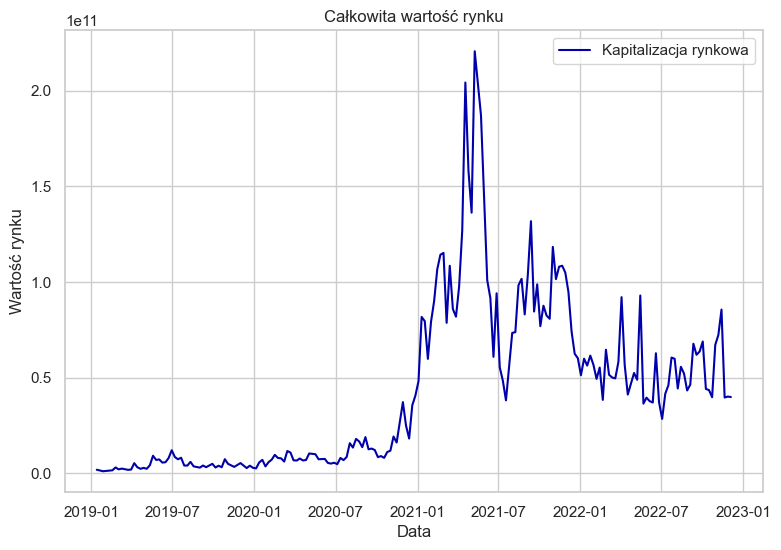

In [368]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(9,6))
ax.set_title('Całkowita wartość rynku')
plt.xlabel('Data')
plt.ylabel('Wartość rynku')
sns.lineplot(data=crypto_market.market, color="#0000ac", label='Kapitalizacja rynkowa')
plt.show()

No powyższym wykresie możemy zauważyć, że wartość rynku kryptowalut była najwyższa w połowie 2021 roku. Po bardzo szybkim wzroście nastąpiło równie szybkie załamanie rynku.

W celu pokazania aktualnego rozkładu kapitalizacji rynkowej na giełdzie Binance, porównamy jej wartości dla ostatniego dnia naszych szeregów czasowych, tj. 12.04.2022.
Porównanie zostanie zwizualizowane na wykresie kołowym dla 10 największych kryptowalut.

In [369]:
crypto_snap = crypto[crypto["date"] == datetime(2022,7,10).date()]
crypto_snap.head(len(crypto_snap))

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread,log_close,log_volume,log_market,log_return,survival_time
182,bitcoin,BTC,Bitcoin,2022-07-10,1.0,19315.830000,22527.370000,19055.310000,20862.470000,5.578073e+05,2.319900e+10,0.520486,0.166426,9.945707,13.231769,23.867375,0.077027,204
386,ethereum,ETH,Ethereum,2022-07-10,2.0,1074.260000,1276.460000,1045.370000,1168.360000,3.780146e+06,8.816502e+09,0.532217,0.197790,7.063356,15.145273,22.899891,0.083969,204
590,binancecoin,BNB,Binance Coin,2022-07-10,3.0,219.200000,247.700000,214.800000,234.700000,1.845989e+06,8.545807e+08,0.604863,0.140179,5.458308,14.428526,20.566122,0.068324,204
794,ripple,XRP,Ripple,2022-07-10,4.0,0.321600,0.359000,0.312800,0.325500,1.027724e+09,6.254055e+08,0.274892,0.141935,-1.122393,20.750612,20.253911,0.012365,204
973,dogecoin,DOGE,DodgeCoin,2022-07-10,5.0,0.067210,0.073500,0.065500,0.067280,2.111150e+09,2.858422e+08,0.222500,0.118906,-2.698892,21.470499,19.470951,0.001041,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11931,winklink,WIN,WINkLink,2022-07-10,96.0,0.000114,0.000124,0.000111,0.000117,1.568460e+11,3.196011e+07,0.427419,0.106164,-9.055047,25.778530,17.279999,0.026900,175
12057,siacoin,SC,Siacoin,2022-07-10,97.0,0.003880,0.004500,0.003680,0.004080,9.482137e+08,7.427297e+06,0.487805,0.200980,-5.501658,20.670090,15.820673,0.050262,126
12183,horizen,ZEN,Horizen,2022-07-10,98.0,13.700000,17.670000,13.390000,16.970000,5.413849e+05,1.939465e+07,0.836449,0.252210,2.831447,13.201886,16.780508,0.214781,126
12250,wax,WAXP,WAX,2022-07-10,99.0,0.092400,0.108300,0.090700,0.106700,5.868189e+07,1.206548e+07,0.909091,0.164948,-2.237734,17.887642,16.305859,0.143894,67


In [370]:
crypto_snap['composition'] = np.where(crypto_snap.ranknow <= 10, crypto_snap.ranknow, 11)
crypto_market_comp = crypto_snap.groupby(by = ['composition'])['market'].sum()

Stworzenie jedynastu przedziałów, które bedą zawierać dziesięć najpopularniejszych kryptowalut oraz wartość zsumowaną od jedynastej do setnej kryptowaluty.

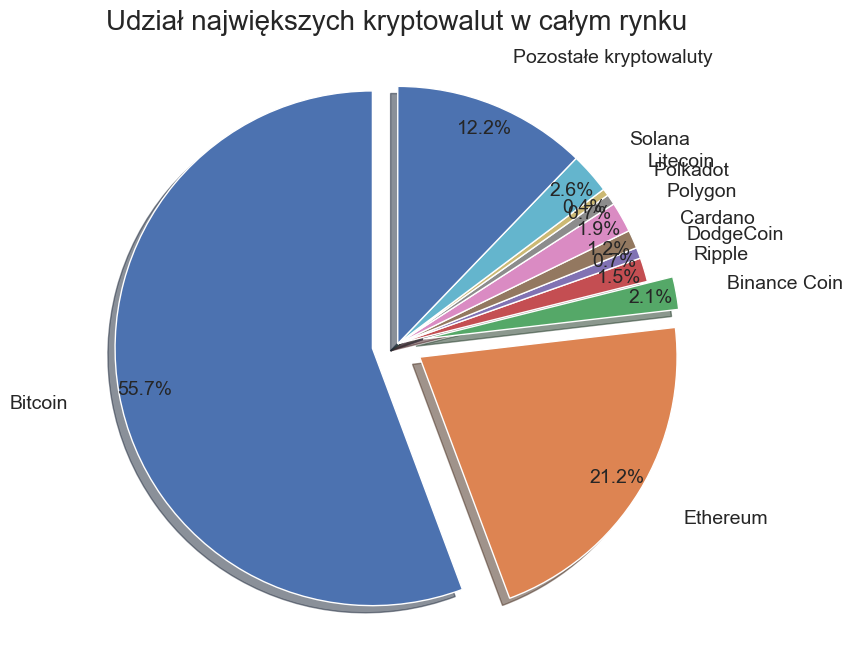

In [371]:
labels = crypto_snap[crypto_snap.ranknow <= 11].name.replace('Uniswap', 'Pozostałe kryptowaluty')
sizes = crypto_market_comp
explode = (0.1, 0.1, 0.1, 0, 0, 0, 0, 0, 0, 0, 0)
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Udział największych kryptowalut w całym rynku', fontsize=20)
ax.pie(sizes, explode = explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={"fontsize":14}, 
        labeldistance=1.2, pctdistance=0.9)
ax.axis('equal')
plt.show()

Jak możemy zauważyć, zdecydowana większość wartości rynku należy do Bitcoina. O ponad połowę mniej warte jest Ethereum, zaś cała reszta zamyka się w 25% kapitalizacji.

In [372]:
crypto_4 = crypto[(crypto.ranknow <= 4)]

## 6. Analiza najpopularniejszych kryptowalut

Analizując najbardziej popularne kryptowaluty od początku 2019 roku największą stabliność wykazuje Bitcoin oraz Ethereum, które w danym przedziale czasowym zawsze zajmowały odpowiednio miejsce 1 i 2. Przez większość czasu, bo aż do początku 2021 roku 3 miejsce cały czas stabilnie należało do Ripple ale wzrost popularności giełdy Binance spowodował, że należąca do nich kryptowaluta zyskała na wartości i od 2021 roku stale jest trzecią najpopularniejszą kryptowalutą. W tym czasie Ripple osylował w top6 pupularnych kryptowalut.  
Można więc z tego wywnioskować, że na przestrzeni ostatnich 4 lat najbardziej stabilnymi kryptowalutami były Bitcoin, Ethereum, BinanceCoin oraz Ripple.


In [373]:
crypto_4 = crypto[(crypto.ranknow <= 4)]

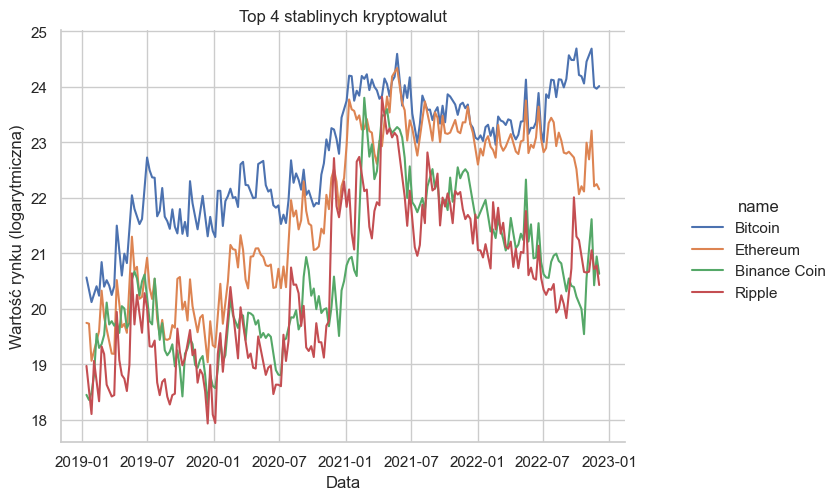

In [374]:
fig = sns.relplot(x = 'date', y = 'log_market', kind = 'line', data = crypto_4, hue = 'name')
fig.fig.set_figwidth(9)
fig.ax.set_title("Top 4 stablinych kryptowalut")
plt.xlabel('Data')
plt.ylabel('Wartość rynku (logarytmiczna)')
plt.show()

Powyższy wykres przedstawia wartość rynkową TOP4 kryptowalut na giełdzie binance. Skala logarytmiczna nie obrazuje jednak rzeczywistej przewagi Bitcoina nad resztą.
Z drugiej strony niezastosowanie skali logarytmicznej sprawi że przebieg wartości pozostałych kryptowalut przybliży się do osi x.

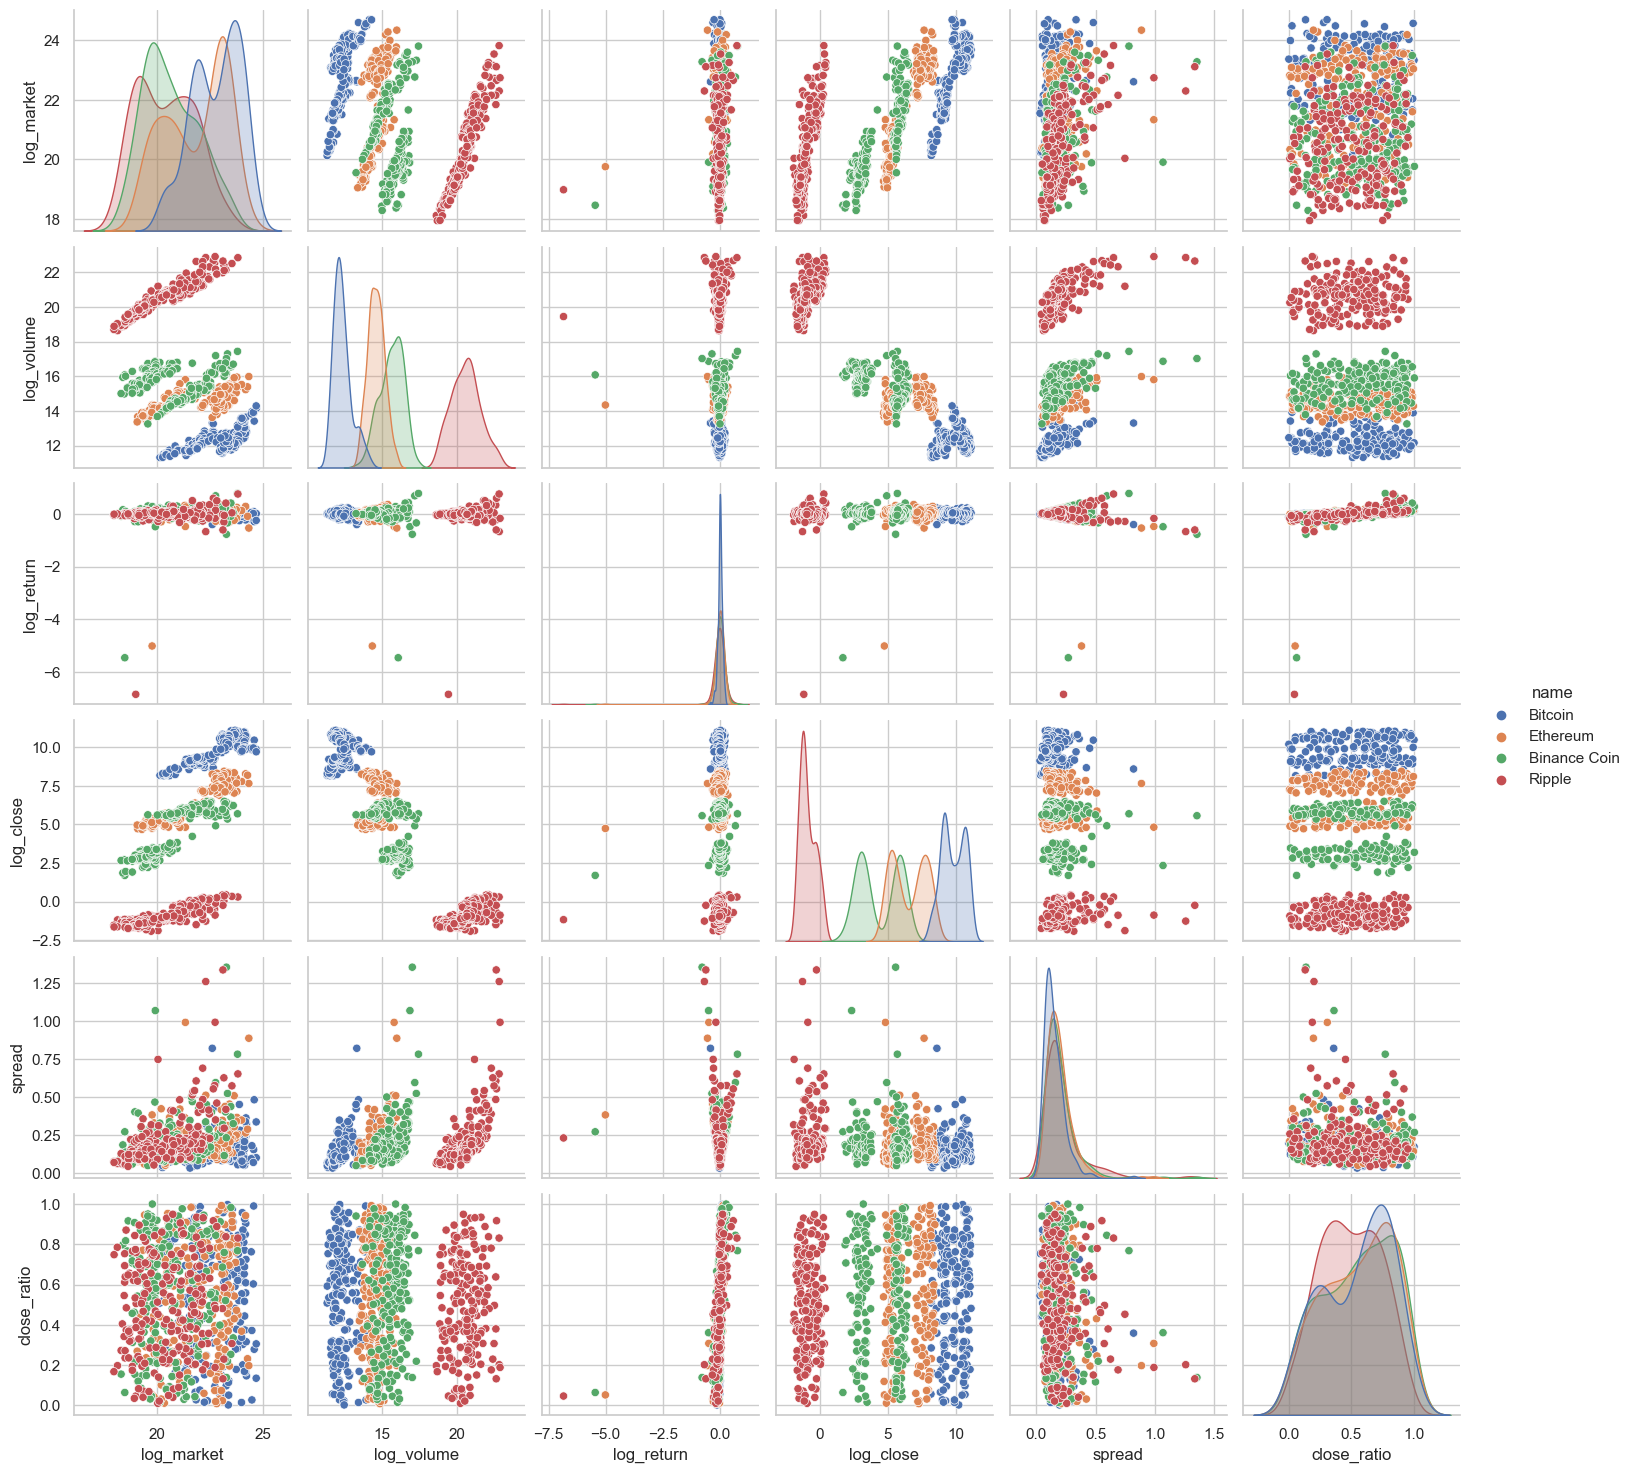

In [375]:
sns.pairplot(crypto_4[['name','log_market','log_volume','log_return','log_close','spread','close_ratio']], hue='name')
plt.show()

Powyższy zbiór wykresów przedstawie zależności pomiędzy pięcioma wartościami (wartość rynku, wolumen zrealizowany, stopa zwrotu, wspołczynnik zamknięcia, tygodniowa amplituda i wartość na zamknięciu dla czterech największych kryptowalut.
Obserwując poszczególne zależności możemy zauważyć, że kombinacje wykresów związane z wolumenem zrealizowanym oraz wartością są rozdzielne. W większości przypadków zbiory te mozna łatwo odseparować dla poszczególnych kryptowalut. Pozostałe zmienne z reguły nachodzą na siebie.

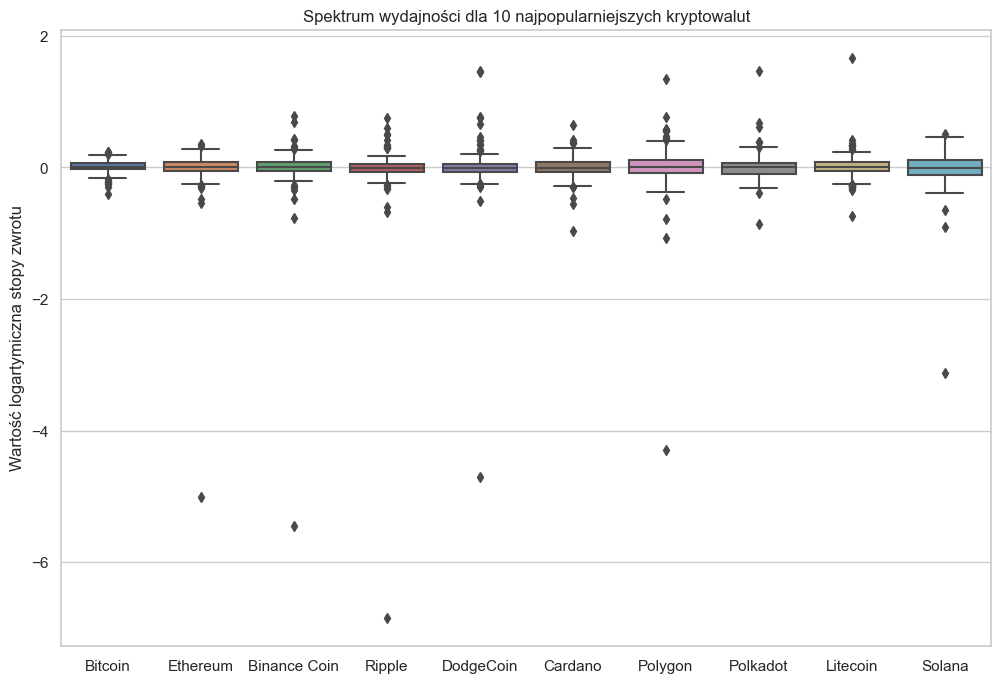

In [376]:
fig, ax = plt.subplots(figsize= (12,8))
sns.boxplot(x='name', y='log_return', data = crypto[crypto.ranknow <= 10], ax = ax)
ax.set_title('Spektrum wydajności dla 10 najpopularniejszych kryptowalut')
ax.set_xlabel('')
ax.set_ylabel('Wartość logartymiczna stopy zwrotu')
plt.show()

Powyższy wykres pudełkowy przedstawia rozkład stopy zwrotu dla poszczegolnych kryptowalut.
Najbardziej nasuwający się wniosek wynika z rozmieszczenia wartości odstających. Możemy zaobserwować, że większość kryptowalut, w przeciwieństwie do Bitcoina, posiada pojedyńcze przypadki zdecydowanych spadków tydzień do tygodnia. Oznacza to, że ich zakup niesie ze sobą niskie, ale możliwe ryzyko gwałtownego spadku wartości.

## 7. Analiza Bitcoina

In [377]:
bitcoin = crypto[crypto.slug == 'bitcoin']
bitcoin['date'] = pd.to_datetime(bitcoin['date'])

Stworzenie zmiennej odpowiedzialnej za wszystkie dane dotyczące tylko Bitcoina

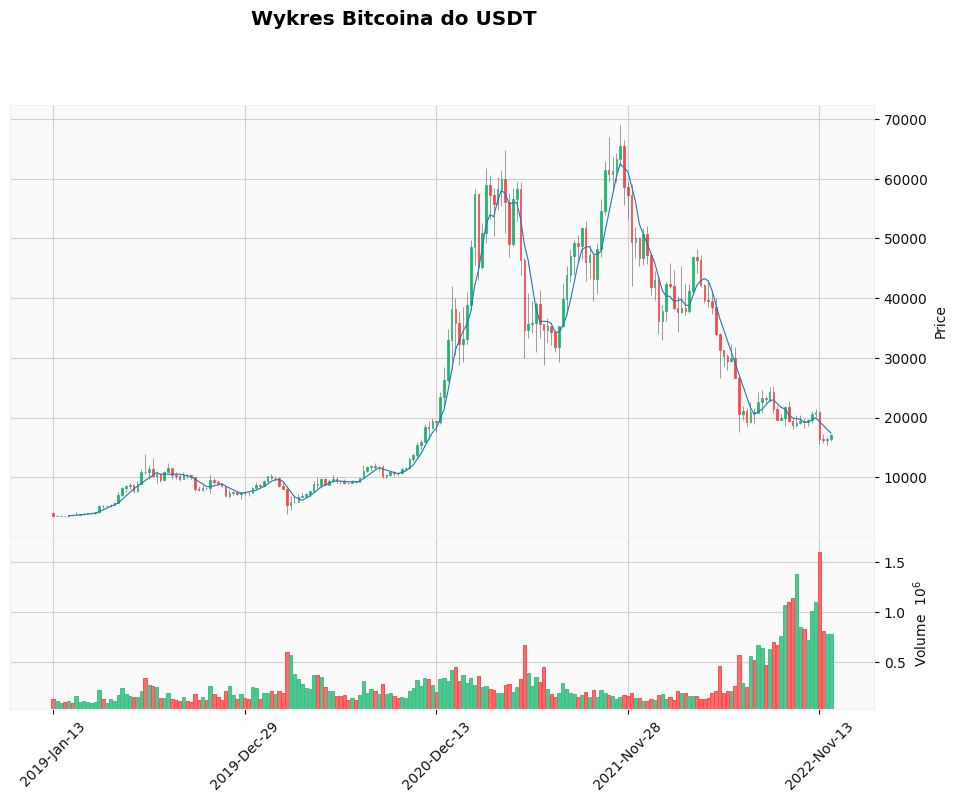

In [378]:
mpf.plot(bitcoin.set_index('date').tail(len(bitcoin)),
        figscale=1.5, type='candle', style='yahoo',
        volume=True, title='Wykres Bitcoina do USDT', mav=(5))

Powyższy wykres przedstawia kurs Bitcoina względem krypotwaluty Tether, która jest cyfrowym odpowiednikiem dolara i oscyluje wokół wartości jednego dolara za token.  

Od 2019 roku duże amerykańskie korporacje zaczęły akceptować nową metodę płatności za pomocą waluty cyfrowej w postaci Bitcoina. Spowodowało to wzrost notowań do 10000$ a następnie oscylację wokół wartości 8500$. Pod koniec roku 2019 wybuchła pandemia Covid w Azji co przełożyło się na kolejny wzrost notowań kryptowaluty. Powodem był początek kryzysu w krajach przeciwstawiających się kryptowalutom jako formie płatności (np. Chiny). W momencie gdy pandemia dotarła do Europy i USA kurs Bitcoina mocno spadł i a tokeny zostały w dużym stopniu wyprzedawane. Pod wpływem niestabilności gospodarki wartość kryptowaluty zaczęła znów wzrastać wyrównując wartość osiągniętą przed pandemią (około 1000$) i stabilizując osiągniętą wartość przez ponad pół roku.  

Pod koniec 2020 roku zaczął się największy w historii Bitcoina wzrost kursu, który sięgnął wartości ponad 61000$. Wartość zmieniła się o ponad 500% w 4 miesiące. Przyczyną dużego wzrostu kursów kryptowalut były skutki kryzysu powstałego przez pandemię. Zaczęto poszukiwać rozwiązania trudnej sytuacji gospodarczej oraz coraz większe firmy tj. Amazon, Bank of New York czy Morgan Stanley pozwalały na dokonywanie transakcji za pomocą Bitcoina. Osoby wpływowe np. Elon Musk zaczęły inwestować w tokeny BTC i rozpowszechniać informacje na ich temat, co również spowodowało wzrost kursu. W pewnym momencie po ustabilizowaniu najwyższej wartości kryptowaluty nastąpiła ogólna panika i nagłe masowe wyprzedanie kryptowaluty przez krótkoterminowych inwestorów. Rezultatem był nagły spadek kursu o ponad 40%. Nowa wartość BTC wynosiła około 33000$. Po masowej panice przyszedł jak zawsze okres wzrostu wartości, który został zatrzymany przez rząd Chin. We wrześniu 2021 roku Ludowy Bank Chin wprowadził zakaz transakcji kryptowalut co odbiło się na notowaniach giełdowych Bitcoina. Wzrost został zahamowany, lecz tylko na krótki okres po, którym wartość Bitcoina sięgnęła rekordowych ponad 64000$ za 1 BTC. Jest to największa wartość Bitcoina w swojej historii. 

Pod koniec 2021 roku rozpoczął się spadek kursu Bitcoina spowodowany korektą notowań. Po długiej hossie jaka wystąpiła w 2021 roku przyszedł czas na bessę. Spadek kurs trwał aż do lutego bieżącego roku kiedy to wartość kryptowaluty osiągnęła duże oscylacje wokół 40000$. Pod wpływem wybuchu wojny między Rosją i Ukrainą wartość Bitcoina pierw wzrosła ale w związku z dużą inflacją oraz niepewnością gospodarczą kurs zaczął ponowie spadać. Kolejnym czynnikiem wpływającym na kurs było coraz mniejsza ilość tokenów możliwych do wydobycia, a co za tym idzie coraz trudniejszy proces. Od czerwca kurs Bitcoina ustabilizował się i oscyluje wokół 20000$ z lekką tendencją spadkową.  

Token BTC jest bardzo związany z aktualną sytuacją polityczną i gospodarczą. Na kurs
kryptowaluty mają duży wpływ zarówno kraje i ich decyzje jak i duże liczące się na giełdzie
spółki. Wartość Bitcoina może być w łatwy sposób manipulowana w zależności od decyzji
podjętych przez osoby wysoko postawionych co ma ujemny wpływ na niezależność
kryptowaluty.


In [379]:
bitcoin.describe()

,ranknow,open,high,low,close,volume,market,close_ratio,spread,log_close,log_volume,log_market,log_return,survival_time
count,204.0,204.000000,204.000000,204.000000,204.000000,2.040000e+02,2.040000e+02,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.0
mean,1.0,23659.739510,25486.211961,21731.535539,23724.031520,2.789147e+05,1.308439e+10,0.545250,0.150576,9.760339,12.314905,22.774710,0.007810,204.0
std,0.0,17765.508196,19030.397275,16134.540639,17717.528633,2.397284e+05,1.188581e+10,0.272440,0.091156,0.827828,0.610240,1.135906,0.096148,0.0
min,1.0,3458.110000,3557.750000,3349.920000,3458.110000,8.169839e+04,5.488407e+08,0.002791,0.032204,8.148477,11.310790,20.123319,-0.404390,204.0
25%,1.0,9018.370000,9586.250000,8504.000000,9061.925000,1.456269e+05,3.197841e+09,0.305517,0.092451,9.111836,11.888800,21.885688,-0.027063,204.0
50%,1.0,18299.440000,19452.560000,16091.635000,18299.710000,1.920382e+05,1.028342e+10,0.605052,0.123094,9.814621,12.165423,23.053799,0.013020,204.0
75%,1.0,38395.367500,42403.677500,34543.155000,38395.370000,2.929799e+05,2.063546e+10,0.767028,0.184464,10.555692,12.587842,23.750277,0.062301,204.0
max,1.0,65519.110000,69000.000000,62278.000000,65519.100000,1.600578e+06,5.292208e+10,0.997225,0.820170,11.090097,14.285875,24.692087,0.230975,204.0


Wyświetlenie statystyk dla każdej kolumny danych Bitcoina:
* 'count' - liczba wierszy, suma długości wszystkich szeregów czasowych
* 'mean' - wartość średnia
* 'std' - wartość odchylenia standardowego
* 'min' - wartość minimalna
* '25%' - kwartyl dolny, percentyl dwudziesty piąty
* '50%' - wartość środkowa, mediana, percentyl pięćdziesiąty
* '75%' - kwartyl górny, percentyl siedemdziesiąty piąty
* 'max' - wartość maksymalna

Powyższa tabela ze statystykami pozwala na dokładniejszą analizę kursu Bitcoina. Wartość minimalna jaką osiągnął Bitcoin od początku 2019 roku wynosi 3349,92$ natomiast największa 69000$. Odchylenie standardowe jest bardzo duże co oznacza duże zróżnicowanie notowań kryptowaluty. Wartość percentyli powierdza, że przez większość czasu wartości osiągały jednak niższe notowania. Wartość średnia wynosi około 23700$ natomiast mediana niecałe 18300$. Występuje dość duża różnica między tymi wartościami co powtierdza duże zróżnicowanie kursu oraz krótkie okresy czasu gdy wartość Bitcoina osiągał największe wartości.

In [380]:
def plot_time_series(time_series, crypto_title):
    fig, (histogram, probability) = plt.subplots(1, 2, figsize=(12, 4))
    histogram.hist(time_series, bins = 20)
    histogram.set_title('Rozkład szeregów czasowych' + ' ' + crypto_title)
    histogram.set_xlabel('stopa zwortu (logarytm)')
    histogram.set_ylabel('częstotliwość')
    stats.probplot(time_series, dist='norm', plot=plt)
    probability.set_title('Wykres prawdopodobieństwa' + ' ' + crypto_title)
    probability.set_xlabel('kwantyle teoretyczne')
    probability.set_ylabel('uporządkowane wartości')
    plt.show()

Funkcja *plot_time_series* służy do tworzenia wykresu rozkładu szeregów czasowych danej kryptowaluty oraz wykresu prawdpodobieństwa, w celu analizy poszczególnych kryptowalut.

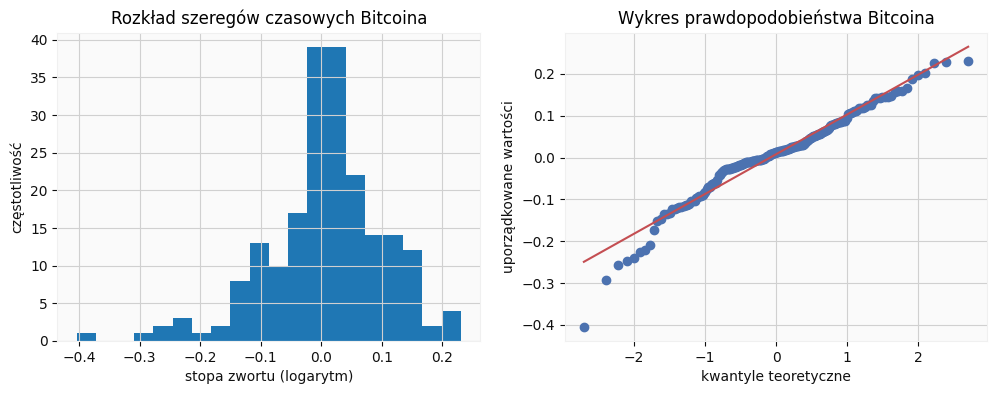

In [381]:
plot_time_series(bitcoin.log_return, 'Bitcoina')

In [382]:
bitcoin_stat = [bitcoin.log_return.mean(), bitcoin.log_return.std(), bitcoin.log_return.skew(), bitcoin.log_return.kurtosis()]
pd.DataFrame(bitcoin_stat, columns = list(["Statystyki Bitcoina"]), 
             index = list(["Średnia arytmetyczna", "Odchylenie standardowe", "Skośność", "Kurtoza"]))

,Statystyki Bitcoina
Średnia arytmetyczna,0.007810
Odchylenie standardowe,0.096148
Skośność,-0.701549
Kurtoza,1.893684


Wyliczone statyski stopy zwrotu Bitcoina pokazują, że odchylenie standardowe jest wysokie w stosunku do wartości średniej.
Skośność równa -0.7 oznacza ogon lewostronny histogramu, co możemy zaobserwować na powyższym wykresie rozkładu stopy zwrotu.
Dodatnia kurtoza mówi o większej ilości dodatnich wartości odstających, co również jest pokazane na wykresie (wyższe słupki z dodatnimi wartościami).
Obie te statystki świadczą o tym, że rozkład stopy zwrotu jest daleki od rozkładu normalnego.

Sprawdzenie maksymalne tygodniowej straty:

In [383]:
bitcoin[bitcoin.log_return == min(bitcoin.log_return)]
print('Makysmalna tygodniowa strata wynosi: ' + str(round(min(bitcoin.log_return)*100, 2)) + '%')
bitcoin[bitcoin.log_return == min(bitcoin.log_return)]

Makysmalna tygodniowa strata wynosi: -40.44%


,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread,log_close,log_volume,log_market,log_return,survival_time
61,bitcoin,BTC,Bitcoin,2020-03-15,1.0,8034.76,8179.31,3782.13,5361.3,595647.065838,6.563455e+09,0.359132,0.82017,8.586962,13.297404,22.604783,-0.40439,204


In [384]:
def max_drawdown(time_series):

    N = len(time_series) # ilość pobranych wierszów danych
    S = [0] * (1+N) # wartość bitcoina w danym momencie
    T = [0] * (1+N) # maksymalna wartość bitcoina do danego momentu
    V = [0] * (1+N) # obsunięcie kapitału
    
    for n in range(1,1+N,1):     
        S[n] = S[n-1] + list(time_series['log_return'])[n-1]    #krzywa wartości kryptowaluty

        #krzywa maksymalnej wartości
        if T[n-1] < S[n]:
            T[n] = S[n]
            k = n
        else: 
            T[n] = T[n-1]

        #krzywa obsunięcia kapitału
        if V[n-1] < S[n]-T[n]:
            V[n] = V[n-1]
        else:
            V[n] = S[n]-T[n]
            
    trading = pd.DataFrame({'wartość kryptowaluty': S[1:], 'wartość maksymalna': T[1:],
                            'obsunięcie kapitału': V[1:]}, index = time_series.date)

    fig = sns.lineplot(data=trading)
    fig.yaxis.set_major_formatter(PercentFormatter(1))
    print('Maksymalne obsunięcie kapitału wynosi: ' + str(round(min(V)*100,2)) + '%')

Funkcja max_drawdown służy do wyrysowania linii pokazującej okres trwania lokalnego maksimum danej kryptowaluty oraz obsunięcia kapitału. Funkcja pozwala również na obliczenie maksymalnego obsunięcia kapitału czyli procentowej straty wartości kryptowaluty.

Maksymalne obsunięcie kapitału wynosi: -139.24%


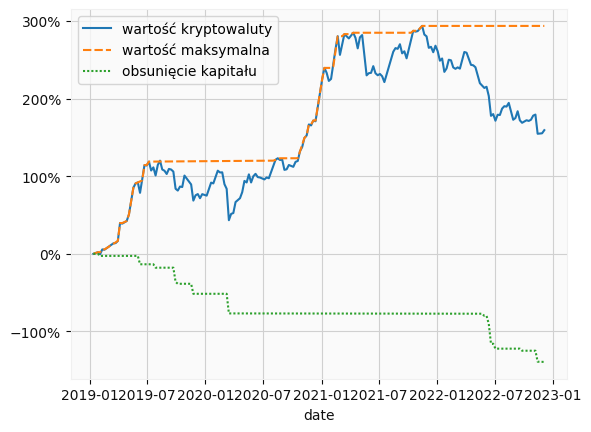

In [385]:
max_drawdown(bitcoin)

Maksymalne obsunięcie kapitału wynosi: -139.24%


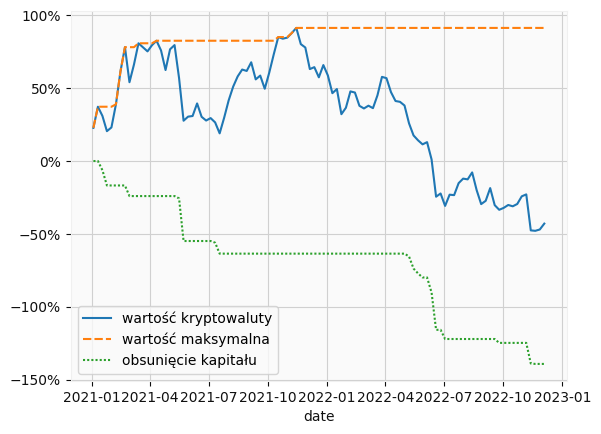

In [386]:
bitcoin.date = pd.to_datetime(bitcoin.date)
max_drawdown(bitcoin[bitcoin.date.dt.year >= 2021])

Na powyższych wykresach przebiegu wartości kryptowaluty zostały dorysowane okresy przedstawiające czas trwania lokalnych maksimów ceny.
Co więcej, wyliczone zostało procentowe obsunięcie kapitału, które jest wyznacznikiem maksymalnej straty jaką możemy ponieść poprzez inwestycję w danym okresie.
Z technicznego punktu widzenia, obsunięcie kapitału to odległość pomiędzy lokalnym maksimum, a następującym po nim lokalnym minimum, tak więc otrzymane wartości przedstawiają teoretycznie największą wartość procentową jaką straciliśmy w stosunku do najwyższego poziomu na jakim dotychczs znalazł się nasz kapitał.

In [387]:
from binance import Client
import quandl
import yfinance as yf
import pandas as pd
import numpy as np
import scipy.stats as stats
from datetime import datetime
import matplotlib.pyplot as plt
from  matplotlib.ticker import PercentFormatter
import seaborn as sns
import mplfinance as mpf
from sklearn import metrics
from sklearn.preprocessing import scale
import sklearn.manifold as skm
import sklearn.decomposition as skd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import statsmodels.formula.api as smf
import warnings

## 8. Analiza kryptowalut względem aktywów na giełdzie

Założeniem tej części analizy jest porównie aktywów cyfrowych z aktywami rzeczywistaymi na giełdach, w celu znalezienia korleacji pomiędzy poszczególnymi aktywami. Spośród wcześniej prezentowanych stu najpopularniejszych kryptowalut wybrano Bitcoina, Ethereum, Binance Coin oraz Ripple. W przypadku aktywów giełdowych wybrano kurs surowców takich jak złoto i srebro. Wybrano również kurs indeksu S&P 500 oraz indeksu dolara czyli stosunek dolara amerykańskiego do koszyka walut obcych.

### 8.1. Pobranie danych z giełdy kryptowalut

In [388]:
interval = Client.KLINE_INTERVAL_1DAY
begin_int = data_change('01 01 2022')
end_int = data_change('10 12 2022')

W celu wykonania dokładniejszej analizy postanowiono zmienić daty na okres od początku do końca 2022 roku. Zmianie uległa również częstotliwość pobierania danych. Dane są aktualizowane dziennie a nie tygodniowo jak było to wykonane podczas pierwszej analizy.

In [389]:
day_coins_list = []
day_coins_list.append(take_coin("bitcoin", 'BTC', 'Bitcoin', 1))
day_coins_list.append(take_coin("ethereum", 'ETH', 'Ethereum', 2))
day_coins_list.append(take_coin("binancecoin", 'BNB', 'Binance Coin', 3))
day_coins_list.append(take_coin("ripple", 'XRP', 'Ripple', 4))

In [390]:
day_data = []
for day_coins in day_coins_list:
    day_data += day_coins

In [391]:
data_df = pd.DataFrame(day_data)
data_df.columns = columns_name
data_df.drop(columns=['Wartość do zignorowania'], axis=1)
data_df[numeric_columns] = data_df[numeric_columns].apply(pd.to_numeric, axis=1)
data_df['Czas otwarcia'] = pd.to_datetime(data_df['Czas otwarcia']/1000, unit='s').dt.date
data_df['Czas zamknięcia'] = pd.to_datetime(data_df['Czas zamknięcia']/1000, unit='s').dt.date

In [392]:
crypto2022 = pd.DataFrame()
crypto2022['slug'] = data_df['Slug']
crypto2022['symbol'] = data_df['Symbol']
crypto2022['name'] = data_df['Nazwa']
crypto2022['date'] = data_df['Czas zamknięcia']
crypto2022['ranknow'] = data_df['Ranking']
crypto2022['open'] = data_df['Kurs na otwarciu']
crypto2022['high'] = data_df['Najwyższy kurs w trakcie dnia']
crypto2022['low'] = data_df['Najniższy kurs w trakcie dnia']
crypto2022['close'] = data_df['Kurs na zamknięciu']
crypto2022['volume'] = data_df['Zmiana wolumenu transakcji kryptowaluty']
crypto2022['market'] = data_df['Ilość kryptowaluty w obiegu'] * data_df['Kurs na zamknięciu']
crypto2022['close_ratio'] = (data_df['Kurs na zamknięciu'] - data_df['Najniższy kurs w trakcie dnia']) / (data_df['Najwyższy kurs w trakcie dnia'] - data_df['Najniższy kurs w trakcie dnia'])

Stworzenie nowej tabeli z przetworzonymi danymi spersonalizowanymi, które zostaną wykorzystane podczas analizy.

In [393]:
crypto2022['log_close'] = np.log(crypto2022.close)
crypto2022['log_volume'] = np.log(crypto2022.volume)
crypto2022['log_market'] = np.log(crypto2022.market)
crypto2022['spread'] = (crypto2022.high - crypto2022.low) / crypto2022.close
crypto2022['log_return'] = np.log(crypto2022.close / crypto2022.close.shift(1))
crypto2022 = crypto2022.replace([np.inf,-np.inf, np.nan], 0)

Wprowadzenie wartości logarytmicznych identycznie jak podczas wcześniejszej analizy. Wykorzystano również zamianę wartości brakujących na wartość równą 0.

In [394]:
bitcoin2022 = crypto2022[crypto2022.slug == 'bitcoin']
ethereum2022 = crypto2022[crypto2022.slug == 'ethereum']
binancecoin2022 = crypto2022[crypto2022.slug == 'binancecoin']
ripple2022 = crypto2022[crypto2022.slug == 'ripple']

In [395]:
crypto_asset = pd.DataFrame(columns =[], index = bitcoin2022.date)
crypto_asset = pd.merge(crypto_asset, bitcoin2022[['date', 'log_return']], 
                        how='inner', left_on = 'date', right_on = 'date')
crypto_asset = pd.merge(crypto_asset, ethereum2022[['date', 'log_return']], 
                        how='inner', left_on = 'date', right_on = 'date')
crypto_asset = pd.merge(crypto_asset, binancecoin2022[['date', 'log_return']], 
                        how='inner', left_on = 'date', right_on = 'date')
crypto_asset = pd.merge(crypto_asset, ripple2022[['date', 'log_return']], 
                        how='inner', left_on = 'date', right_on = 'date')
crypto_asset.columns = ['Date','Bitcoin', 'Ethereum', 'Binance Coin', 'Ripple']
crypto_asset = crypto_asset.set_index('Date')
crypto_asset.index = pd.to_datetime(crypto_asset.index)

Stworzenie tabeli zawierającej datę oraz wartość logarytmiczną zwrotu dla wcześniej podanych kryptowalut. Dane zawarte w tabeli są odpowiednio przetworzone.

In [396]:
crypto_asset.head(len(crypto_asset))

,Bitcoin,Ethereum,Binance Coin,Ripple
Date,,,,
2022-01-01,0.000000,-1.514793,-0.876124,-5.825350
2022-01-02,-0.009188,0.016522,0.006992,0.009244
2022-01-03,-0.017926,-0.016429,-0.036633,-0.030990
2022-01-04,-0.013310,0.005091,-0.009816,-0.011600
2022-01-05,-0.053346,-0.066770,-0.066895,-0.062952
...,...,...,...,...
2022-12-06,0.007201,0.009412,0.006222,0.005380
2022-12-07,-0.014875,-0.032083,-0.020892,-0.020390
2022-12-08,0.022752,0.039028,0.021581,0.027265


### 8.2. Pobieranie danych aktywów rzeczywistych z giełdy

In [397]:
quandl.ApiConfig.api_key = 'jou3Hy9N_sKPZxy9mgxt'

Dostęp do danych zawartych na stronie data.nasdaq (dawniej quandl) uzyskujemy poprzez specjalny klucz dostępu (*api_key*).

In [398]:
start = datetime(2022, 1, 1)
end = datetime(2022, 12, 10)

Wprowadzenie przedziału czasowowego zgodnego z poprzednim podpunktem, w któym pobierano dane dla trzech kryptowalut również od początku roku 2022.

In [399]:
gold_price = quandl.get("LBMA/GOLD", start_date = start, end_date = end)
silver_price = quandl.get("LBMA/SILVER", start_date = start, end_date = end)
stock_index = yf.download("^GSPC", start, end)
USD_index = yf.download('DX-Y.NYB', start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Dane notowań złota i srebra względem różnych walut w zdefiniowanych wcześniej ramach czasowych pobrano z data.nasdaq. Pobrano również notowania indeksu S&P 500 oraz indeksu dolara ze strony Yahoo Finance.

In [400]:
gold_price.index = gold_price.index.date
silver_price.index = silver_price.index.date
stock_index.index = stock_index.index.date
stock_index.drop(index=stock_index.index[0], axis=0, inplace=True)
USD_index.index = USD_index.index.date
USD_index.drop(index=USD_index.index[0], axis=0, inplace=True)

In [401]:
stock_market_asset = pd.merge(gold_price, silver_price, left_index=True, right_index=True)
stock_market_asset = pd.merge(stock_market_asset, stock_index, left_index=True, right_index=True)
stock_market_asset = pd.merge(stock_market_asset, USD_index, left_index=True, right_index=True)
stock_market_asset = stock_market_asset[['USD (AM)', 'USD',  'Adj Close_x', 'Adj Close_y']]
stock_market_asset.columns = ['Kurs złota', 'Kurs srebra', 'Kurs S&P 500', 'Kurs USD']

Połączenie w tabelę wcześniej pobranych danych aktyw giełdowych. Pozostawiona zostaje jedyna cena na zamknięciu każdego dnia.

In [402]:
stock_market_asset.head(len(stock_market_asset))

,Kurs złota,Kurs srebra,Kurs S&P 500,Kurs USD
2022-01-04,1809.05,22.890,4793.540039,96.290001
2022-01-05,1818.50,23.055,4700.580078,96.190002
2022-01-06,1804.95,22.245,4696.049805,96.250000
2022-01-07,1792.20,22.240,4677.029785,95.739998
2022-01-10,1800.55,22.455,4670.290039,95.989998
...,...,...,...,...
2022-12-05,1794.35,22.985,3998.840088,105.290001
2022-12-06,1773.35,22.540,3941.260010,105.580002
2022-12-07,1771.85,22.385,3933.919922,105.099998
2022-12-08,1782.45,22.695,3963.510010,104.769997


Kolejno wszystkie ceny zostają zamienione na logarytmiczną stopę zwrotu.

In [403]:
for col in stock_market_asset.columns:
    stock_market_asset[col] = np.log(stock_market_asset[col] / stock_market_asset[col].shift(1))
stock_market_asset.head(len(stock_market_asset))
stock_market_asset.drop(index=stock_market_asset.index[0], axis=0, inplace=True)

In [404]:
crypto_asset = crypto_asset.loc[crypto_asset.index.isin(stock_market_asset.index)]
crypto_asset.head(len(crypto_asset))

,Bitcoin,Ethereum,Binance Coin,Ripple
Date,,,,
2022-01-05,-0.053346,-0.066770,-0.066895,-0.062952
2022-01-06,-0.008524,-0.038528,-0.003169,0.008378
2022-01-07,-0.035818,-0.062863,-0.053233,-0.020357
2022-01-10,-0.001007,-0.022228,-0.032433,-0.017550
2022-01-11,0.021450,0.049688,0.087639,0.040265
...,...,...,...,...
2022-12-05,-0.008180,-0.015756,-0.011720,-0.000514
2022-12-06,0.007201,0.009412,0.006222,0.005380
2022-12-07,-0.014875,-0.032083,-0.020892,-0.020390


Pozostawione zostały jedynie wspólne daty, tak by liczba wierszy się zgadzała. Taki zabieg jest niezbędny ze względu na prace giełdy jedynie w dni robocze, podczas gdy giełda kryptowalut jest aktywna codziennie.

In [405]:
eight_assets = pd.merge(crypto_asset, stock_market_asset, left_index=True, right_index=True)
eight_assets.head(len(eight_assets))

,Bitcoin,Ethereum,Binance Coin,Ripple,Kurs złota,Kurs srebra,Kurs S&P 500,Kurs USD
Date,,,,,,,,
2022-01-05,-0.053346,-0.066770,-0.066895,-0.062952,0.005210,0.007183,-0.019583,-0.001039
2022-01-06,-0.008524,-0.038528,-0.003169,0.008378,-0.007479,-0.035765,-0.000964,0.000624
2022-01-07,-0.035818,-0.062863,-0.053233,-0.020357,-0.007089,-0.000225,-0.004058,-0.005313
2022-01-10,-0.001007,-0.022228,-0.032433,-0.017550,0.004648,0.009621,-0.001442,0.002608
2022-01-11,0.021450,0.049688,0.087639,0.040265,0.002579,0.005994,0.009118,-0.003862
...,...,...,...,...,...,...,...,...
2022-12-05,-0.008180,-0.015756,-0.011720,-0.000514,-0.003560,0.016671,-0.018056,0.007053
2022-12-06,0.007201,0.009412,0.006222,0.005380,-0.011772,-0.019550,-0.014504,0.002751
2022-12-07,-0.014875,-0.032083,-0.020892,-0.020390,-0.000846,-0.006900,-0.001864,-0.004557


Połączenie tabeli z danymi kryptowalut oraz notowań giełdowych, w celu analizy korelacji między tymi notowaniami.

### 8.3. Analiza korelacji

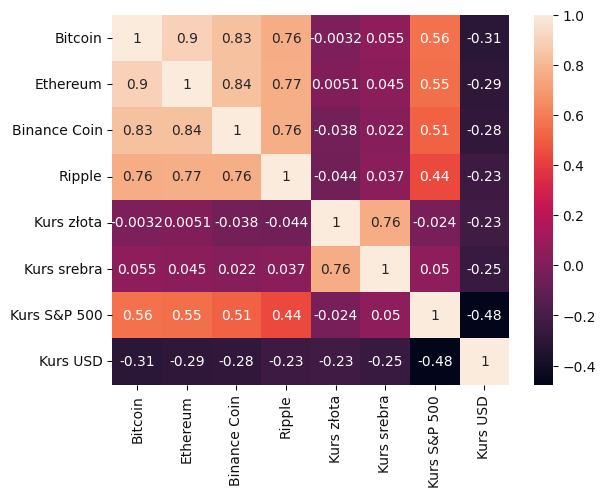

In [406]:
corr_matrix = eight_assets.corr()
sns.heatmap(corr_matrix, annot = True)
plt.show()

Powyższy wykres prezentuje macierz korelacji  stopy zwrotu opisanych wyżej aktywów. Można zauważyć, że korelacja pomiędzy wszystkimi kryptowalutami jest bardzo silna i wynosi co najmniej 0,76 a maksymalnie 0,9 (pomijając korelację między tymi samymi aktywami).  
W przypadku surowców występują takie same zależności co między kryptowalutami co oznacza, że kurs złota i srebra są mocno ze sobą skorelowane. Jeśli sprawdzimy wpływ kryptowalut na owe surowce korelacja jest bliska wartości 0 co oznacza, że nie występuje praktycznie żadna korelacja między nimi.  
Trzecim aktywem rzeczywistym są notowania S&P 500, które wykazują korelację w stopniu umiarkowanym z kryptowalutami. Największą korelację mają zarówno Bitcoin oraz Ethereum jako kryptowaluty najbardziej wpływowe na rynku. Powiązanie notowań indeksu S&P 500 z wartością złota i srebra jest znikome.
Ostatnim analizowanym aktywem jest indeks dolara  W wszystkich przypadkach indeks dolara jest skorelowany z innymi aktywami jako główna waluta transakcji na świecie. Co ważne korelacja we wszystkich przypadkach jest ujemna czyli wzrost wartości dolara powoduje obniżenie wartości notowań pozostałych aktywów. Korelacja dolara z kryptowalutami oraz surowcami jest słaba i wynosi odpowiednio około -0,3 i -0,25. Korelacja względem indeksu S&P 500 wynosi -0,48, co potwierdza poprawność wykonania przetwarzania danych.

## 9. Zastosowanie wybranych algorytmów uczenia maszynowego

W tym rozdziale stworzony zostanie model bazowy służący do pogrupowania wszystkich analizowanych kryptowalut. Po odpowiednim przygotowaniu danych wykonane zostanie:
- zmniejszenie wymiarowości za pomocą metody PCA
- klastrowanie metodą k-średnich
- ocena modeli za pomocą współczynników: Silhoutte Score oraz indeks Calińskiego-Harabasza
- przedstawienie wyników klasteryzacji

Oczekiwanym rezultatem klasteryzacji jest pogrupowanie kryptowalut, dzięki czemu możliwa będzie ocena, w które z nich warto zainwestować, a których lepiej unikać.

### 9.1. Przygotowanie danych

In [407]:
crypto_mean = pd.DataFrame(crypto.groupby('slug').mean())

Dane wykorzystywane w klastrowaniu nie mogą przyjmować formy szeregów czasowych. Od teraz każda kryptowaluta będzie posiadać jedną wartość w każdej kolumnie. W tym celu obliczona została średnia wartość dla wszystkich kompentów danej kryptowaluty.

In [408]:
crypto_log_return = crypto.groupby('slug').log_return
ret_std = pd.DataFrame(crypto_log_return.std())
ret_skew = pd.DataFrame(crypto_log_return.skew())
ret_kurt = pd.DataFrame(crypto_log_return.apply(pd.DataFrame.kurt))

ret_std.columns = ['std']
ret_skew.columns = ['skew']
ret_kurt.columns = ['kurt']

Ponadto obliczone zostały dodatkowe wskaźniki bazujące na średniej z logarytmicznej stopy zwrotu każdej kryptowaluty:
- odchylenie standardowe
- skośność
- kurtoza

In [409]:
df = pd.merge(crypto_mean, ret_std, on = 'slug')
df = pd.merge(df, ret_skew, on = 'slug')
df = pd.merge(df, ret_kurt, on = 'slug')
df.dropna(inplace = True)

In [410]:
df.sort_values('ranknow').head()

,ranknow,open,high,low,close,volume,market,close_ratio,spread,log_close,log_volume,log_market,log_return,survival_time,std,skew,kurt
slug,,,,,,,,,,,,,,,,,
bitcoin,1.0,23659.739510,25486.211961,21731.535539,23724.031520,2.789147e+05,1.308439e+10,0.545250,0.150576,9.760339,12.314905,22.774710,0.007810,204.0,0.096148,-0.701549,1.893684
ethereum,2.0,1314.635882,1441.756520,1180.654559,1320.146225,2.510226e+06,6.651557e+09,0.552388,0.195507,6.538157,14.584371,21.815476,-0.012711,204.0,0.373531,-11.915828,159.509237
binancecoin,3.0,184.456121,203.660696,165.569820,185.851130,7.965848e+06,2.213593e+09,0.553311,0.199966,4.348579,15.614153,20.643516,-0.007246,204.0,0.412037,-11.458752,152.222948
ripple,4.0,0.487892,0.549067,0.430190,0.488034,1.405705e+09,1.801417e+09,0.489276,0.217732,-0.892155,20.591583,20.402507,-0.032446,204.0,0.503252,-12.294946,167.234800
dogecoin,5.0,0.087678,0.103420,0.073893,0.088225,7.296954e+09,2.246882e+09,0.454912,0.251911,-3.797532,21.695543,18.593828,-0.007374,179.0,0.415834,-7.569362,93.306307


Wybranie danych do klastrowania:

In [411]:
df = df[['close_ratio', 'spread', 'log_market', 'log_volume', 'log_close', 'log_return', 'std', 'skew', 'kurt']]
df

,close_ratio,spread,log_market,log_volume,log_close,log_return,std,skew,kurt
slug,,,,,,,,,
1inchnetwork,0.459766,0.328432,18.588021,17.300170,0.579122,-0.012430,0.193209,-0.230027,3.473053
aave,0.479666,0.308444,19.233919,13.436724,5.099144,0.053185,0.552261,8.763503,86.893004
algorand,0.453142,0.283847,18.278901,18.221501,-0.661236,0.005546,0.288618,6.802630,72.888298
amp,0.278006,0.226610,16.241162,19.842580,-4.308273,-0.110280,0.418625,-6.814104,48.606836
ankr,0.439980,0.325128,16.783145,20.144555,-4.075641,-0.024612,0.469527,-9.904553,120.315089
...,...,...,...,...,...,...,...,...,...
waves,0.449091,0.289203,17.509529,15.357694,1.446488,-0.002412,0.189623,-0.019559,3.434542
wax,0.447308,0.297511,17.395406,18.353696,-1.642644,-0.077713,0.445931,-6.470252,48.557921
winklink,0.404516,0.279241,17.415594,25.343371,-8.588089,-0.077344,0.940121,-12.192324,157.671522


Model klastrujący nie może zawierać naszych wszystkich kolumn, gdyż niektóre z nich nie mają żadnego wpływu na przynależność kryptowaluty pod kątem opłacalności. Badania danych takich jak ceny w ciągu dnia lub ranking krytpowaluty niepotrzebnie zakłamałyby otrzymane wyniki.
W tym celu pozostawione zostaną jedynie następujące parametry:
- stosunke ceny zamknięcia do otwarcia
- spread
- logarytm kapitalizacji rynkowej
- logorytm wolumenu
- logartm średniej ceny zamknięcia
- średnia logarytmiczna stopa zwrotu wraz z jej odchyleniem standardowym, skośnością i kurtozą

In [412]:
crypto_scaled = scale(df)
crypto_scaled.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

Ostatecznie wszystkie wykorzystywane dalej wartości zostają przeskalowne, tak by ich średnia była równa 0, a wariancja 1.

### 9.2. Redukcja wymiarowości za pomocą Analizy Składowych Głównych (PCA)

Przygotowany zbiór poddany zostanie redukcji wymiarowości metodą PCA. Naszym celem jest pozostawienie jak największej ilości wariancji oryginalnego zbioru. Sam algorytm PCA bazuje na liniowej redukcji wymiarowości przy użyciu rozkładu wartości osobliwych. Polega on na rzutowaniu danych do przestrzeni o mniejszej liczbie wymiarów tak, aby jak najlepiej zachować strukturę danych. Analiza PCA opiera się o wyznaczanie osi zachowującej największą wartość wariancji zbioru uczącego. Składowe wyznaczamy jako kombinacje liniową badanych zmiennych. Idea tworzenia kolejnych składowych polega na tym, że kolejne składowe nie są skorelowane ze sobą oraz mają na celu zmaksymalizować zmienność, która nie została wyjaśniona przez poprzednią składową. Jako wstępny etap jest tu również wykorzystywana standaryzacja danych.

In [413]:
pca = PCA(n_components=4)
crypto_pca1 = pca.fit_transform(crypto_scaled)

Na początku wykorzystane będą 4 składowe komponenty PCA, w celu zbadania ile informacji zostanie zachowanych.

In [414]:
df_crypto_pca1 = pd.DataFrame(data=crypto_pca1,
                             columns=["PC 1", "PC 2", "PC 3", "PC4"])
df_crypto_pca1.head()

,PC 1,PC 2,PC 3,PC4
0,-0.172191,-0.210540,0.492125,-1.177221
1,-2.234535,-0.263811,0.522356,1.048246
2,-0.208823,-0.149446,-0.350942,0.011465
3,2.716515,1.701024,-1.506939,-0.816227
4,1.880847,-0.605972,-1.116188,0.212009


In [415]:
print("Przy {} komponentach składowych pozostało {:.2f}% początkowej wariancji zbioru".format(4, pca.explained_variance_ratio_.sum()*100))

Przy 4 komponentach składowych pozostało 78.38% początkowej wariancji zbioru


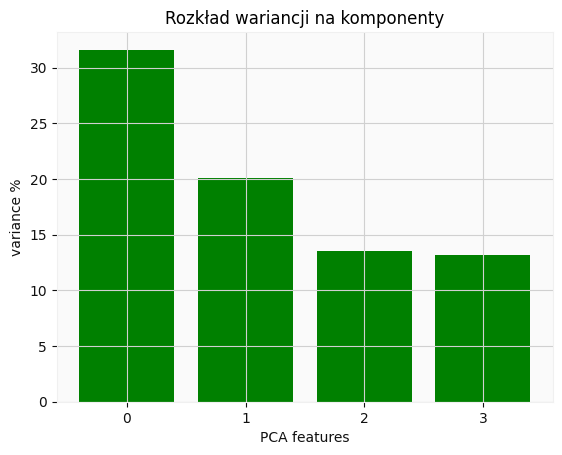

In [416]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_*100, color='green')
plt.title('Rozkład wariancji na komponenty')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.show()

W celu zachowania jak największej ilości informacji i jak najmniejszej ilości komponentów model PCA zostanie dostosowany tak, by zachował 90% wariancji.

In [417]:
pca2 = PCA(n_components=.90)
crypto_pca = pca2.fit_transform(crypto_scaled)

In [418]:
transformed_crypto_pca = pd.DataFrame(data=crypto_pca)
transformed_crypto_pca.head()

,0,1,2,3,4,5
0,-0.172191,-0.210540,0.492125,-1.177221,0.607943,0.261354
1,-2.234535,-0.263811,0.522356,1.048246,0.191015,0.232522
2,-0.208823,-0.149446,-0.350942,0.011465,-0.145460,0.974179
3,2.716515,1.701024,-1.506939,-0.816227,0.104251,-1.292999
4,1.880847,-0.605972,-1.116188,0.212009,-1.403451,-0.586729


In [419]:
print("Przy {} komponentach składowych pozostało {:.2f}% początkowej wariancji zbioru".format(len(transformed_crypto_pca.columns), pca2.explained_variance_ratio_.sum()*100))

Przy 6 komponentach składowych pozostało 93.57% początkowej wariancji zbioru


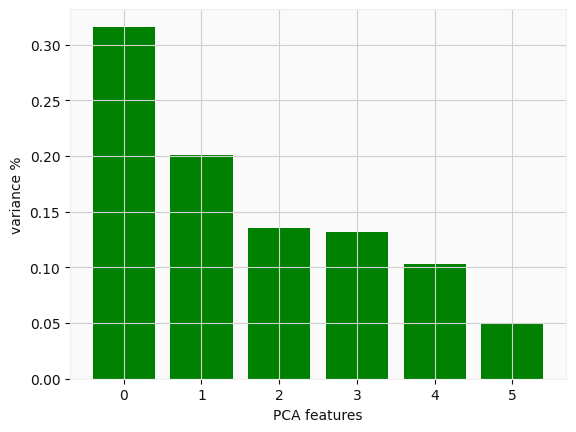

In [420]:
features = range(pca2.n_components_)
plt.bar(features, pca2.explained_variance_ratio_, color='green')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.show()

### 9.3. Klastrowanie metodą k-średnich

Algorytm centroidów polega na znalezieniu liczby k-punktów będących "środkami ciężkości" centroidów w zbiorze danych. Środek ciężkości to lokalizacja reprezentująca środek pomiędzy wszystkimi pobliskimi punktami. Pierwsze środki ciężkości generujemy losowo i musi być ich tyle, na ile klastrów chcemy podzielić nasz zbiór danych, a w następnych krokach dokonujemy iteracyjne obliczenia w celu optymalizacji pozycji centroidów. Algorytm zatrzymuje swoje działanie, gdy centroidy (czyli *i* nie zmieniają się już, czyli ustabilizowały się, a także wówczas, gdy zdefiniowana liczba iteracji została osiągnięta. Warto zaznaczyć, że tego typu podejście nie wykrywa klastrów wklęsłych.

#### 9.3.1. Klastrowanie całego zbioru danych

In [421]:
inertia = []
k = list(range(1, 16))
for i in k:
    km = KMeans(n_clusters=i, random_state=42)
    km.fit(crypto_scaled)
    inertia.append(km.inertia_)

Przyjęto liczbę klastrów (*n_clusters*) równą zmiennej *i*. W przykładzie powyższym wykorzystano inercję, czyli bezwładność, która zakłada, że powstałe klastry składają sie z grup wypukłych punktów. Inercja jest obliczana, jako odległość pomiędzy daną kolumną (wierszem, punktem), a średnią wartością dla kolumn (wierszy). Im większa inercja tym punkty są oddalone dalej od średniego profilu wiersza/kolumny. Słabo sprawdza się ona przy klastrach o bardziej wydłużonych i nieróżnorodnych kształtach.

In [422]:
silhouttescore = []
ch_index = []
k = list(range(2, 16))
for i in k:
    kmeans = KMeans(n_clusters=i, random_state=42).fit(crypto_scaled)
    silhouttescore.append(metrics.silhouette_score(crypto_scaled, kmeans.labels_))
    ch_index.append(metrics.calinski_harabasz_score(crypto_scaled, kmeans.labels_))

Wykorzystano listę *silhouette_score* oraz *ch_index* do zapisania wyników współczynnika silhouette (średni współczynnik sylwetki) oraz indeksu CH wszystkich próbek. W obu przypadkach największa wartość definiuje najbardziej korzystną liczbę klastrów. Indeks CH został wyliczony na podstawie wzoru:
$$
CH = \frac{b}{a},
$$
 gdzie:  
 a - średnia odległość między punktami w klastrze do środka ciężkości danego klastra (spójność),  
 b - średnia ogległość między środkami ciężkości klastra od globalnego środka ciężkości (separacja).  

Indeks Calińskiego-Harabasza informuje o podobieństwie między obiektu do własnego skupienia względem innych skupień. Im większa wartość indeksu tym klastry są gęstrze i dobrze rozdzielone. Wyliczona wartość indeksu pozwala na określenie najbardziej korzystnej liczby klastrów oraz pozwala na porównanie algorytmów klastrowania między sobą.  
Wartość silhouette została wylicozna na podstawie wzoru:
$$
silhouette = \frac{(b-a)}{max(a,b)},
$$
 gdzie:  
 a - średnia odległość między punktami klastra,  
 b - średnia ogległość od najbliższego klastra dla każdego punktu.  

Z powyższego wzoru można zauważyć, że jeśli *a* będzie większe od *b*, to konkretna obserwacja ma dalej do obserwacji w swojej grupie (średnia odległość), a bliżej do obserwacji w sąsiedniej. Wówczas nasze równanie przyjmuje formę wzoru:
$$
\frac{(b-a)}{a} = \frac{b}{a} - 1,
$$
Skoro *a* było większe, to *b/a* będzie mniejsze niż 1, czyli całe równanie będzie mniejsze od 0. Analogicznie, jeśli *a* będzie mniejsze od *b* uzyska się wartość większą od 0.  
Z jednej strony, wartość *a* informuje o bliskości innych elementów wewnątrz grupy. Nie jest to zasadniczo gęstość, ale dostarcza informacji o cisno upakowanej grupie. Z kolei wartość *b* pokazuje, jak daleko znajduje się punkt od najbliższej innej grupy. Czyli mówi o separacji. Im większa, tym lepiej punkty są od siebie odeseparowane. Najlepiej więc, aby *a* było małe (blisko do „sojuszników”), i *b* duże (daleko do „wrogów”). Wyznaczenie maksymalnej wartości silhouette może pozwolić na poprawne określenie rozwiązania problemu separacja-koncentracja i w ten sposób umożliwia wyznaczenie najlepszego *k*. Można zaznaczyć, że algorytm informuje również o tym, czy dana funkcja grupująca poprawnie pogrupowała wartości. Jeśli współczynnik sylwetki wyjdzie ujemny, oznacza to, że uzyskano błędnie pogrupowane wartości.
 

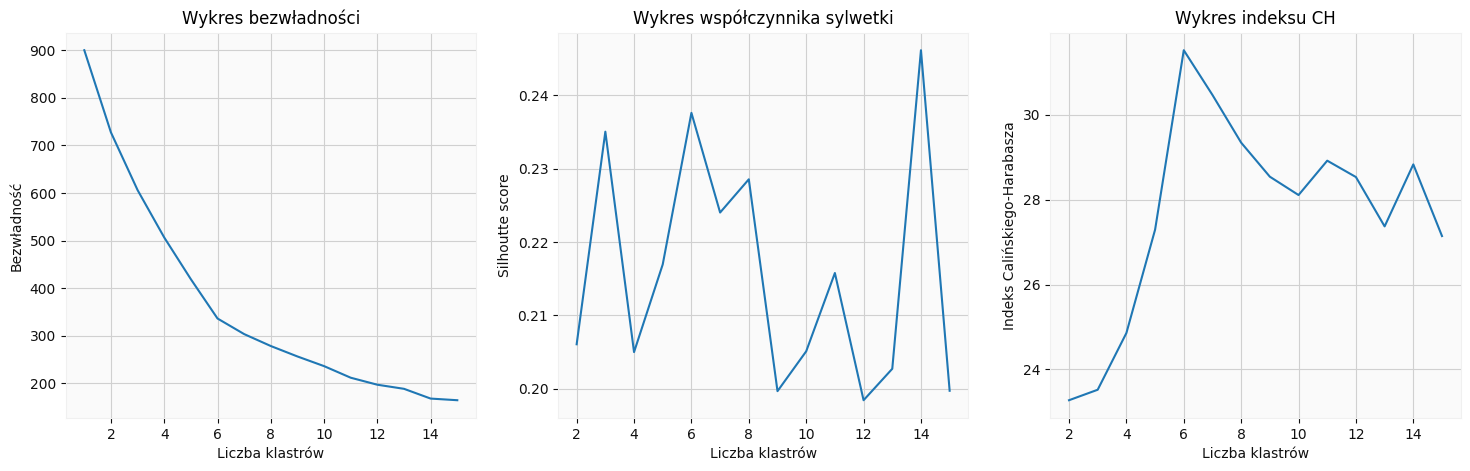

In [423]:
fig, ax = plt.subplots(1,3,figsize=(18,5))
fig1 = sns.lineplot(x = range(1,16,1), y = inertia, ax=ax[0])
ax[0].set_title('Wykres bezwładności')
ax[0].set_xlabel('Liczba klastrów')
ax[0].set_ylabel('Bezwładność')
fig2 = sns.lineplot(x = range(2,16,1), y = silhouttescore, ax=ax[1])
ax[1].set_title('Wykres współczynnika sylwetki')
ax[1].set_xlabel('Liczba klastrów')
ax[1].set_ylabel('Silhoutte score')
fig3 = sns.lineplot(x = range(2,16,1), y = ch_index, ax=ax[2])
ax[2].set_title('Wykres indeksu CH')
ax[2].set_xlabel('Liczba klastrów')
ax[2].set_ylabel('Indeks Calińskiego-Harabasza')
plt.show()

#### 9.3.2. Klastrowanie zbioru zredukowanego przez PCA

W tym podejściu wykorzystujemy metodę redukcji wymiarowości PCA po której stosujemy algorytm k-średnich. Występuje zatem powtórzenie etapów poprzedniego klastrowania:

In [424]:
inertia_pca = []
k = list(range(1, 16))
for i in k:
    km = KMeans(n_clusters=i, random_state=42)
    km.fit(transformed_crypto_pca)
    inertia_pca.append(km.inertia_)

In [425]:
silhouttescore_pca = []
ch_index_pca = []
k = list(range(2, 16))
for i in k:
    kmeans = KMeans(n_clusters=i, random_state=42).fit(transformed_crypto_pca)
    silhouttescore_pca.append(metrics.silhouette_score(transformed_crypto_pca, kmeans.labels_))
    ch_index_pca.append(metrics.calinski_harabasz_score(transformed_crypto_pca, kmeans.labels_))

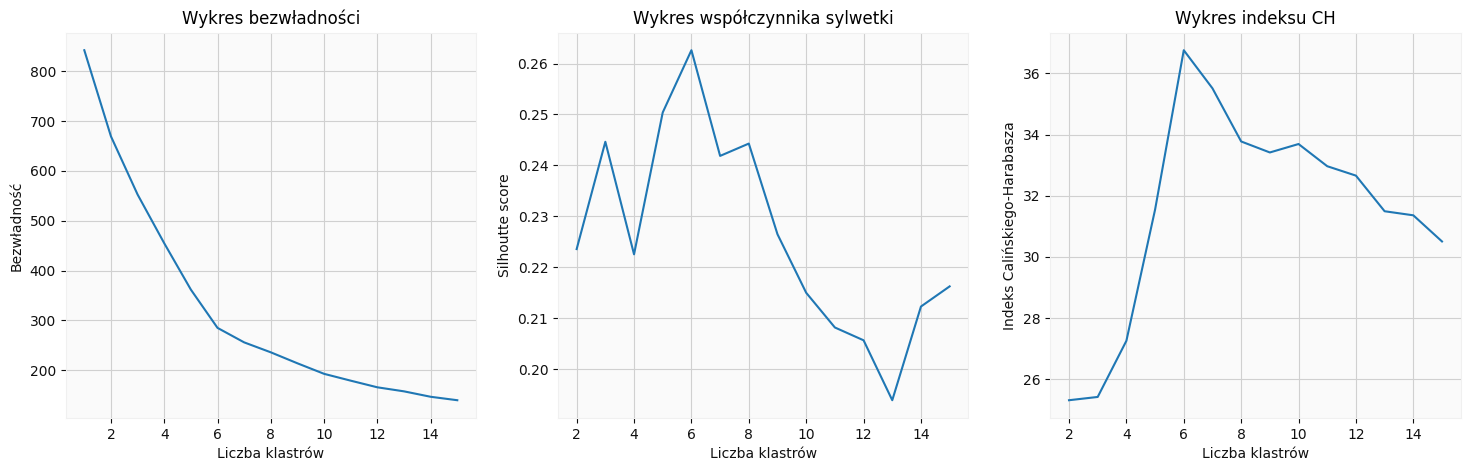

In [426]:
fig, ax = plt.subplots(1,3,figsize=(18,5))
fig1 = sns.lineplot(x = range(1,16,1), y = inertia_pca, ax=ax[0])
ax[0].set_title('Wykres bezwładności')
ax[0].set_xlabel('Liczba klastrów')
ax[0].set_ylabel('Bezwładność')
fig2 = sns.lineplot(x = range(2,16,1), y = silhouttescore_pca, ax=ax[1])
ax[1].set_title('Wykres współczynnika sylwetki')
ax[1].set_xlabel('Liczba klastrów')
ax[1].set_ylabel('Silhoutte score')
fig3 = sns.lineplot(x = range(2,16,1), y = ch_index_pca, ax=ax[2])
ax[2].set_title('Wykres indeksu CH')
ax[2].set_xlabel('Liczba klastrów')
ax[2].set_ylabel('Indeks Calińskiego-Harabasza')
plt.show()

#### 9.3.3. Wybranie najlepszego modelu

In [427]:
print("Wartości wskaźników dla modelu bez PCA:")
print("Silhoutte score: {:.3f}".format(max(silhouttescore)))
print("Indeks Calińskiego-Harabasza: {:.2f}".format(max(ch_index)))
print()
print("Wartości wskaźników dla modelu z PCA:")
print("Silhoutte score: {:.3f}".format(max(silhouttescore_pca)))
print("Indeks Calińskiego-Harabasza: {:.2f}".format(max(ch_index_pca)))

Wartości wskaźników dla modelu bez PCA:
Silhoutte score: 0.246
Indeks Calińskiego-Harabasza: 31.52

Wartości wskaźników dla modelu z PCA:
Silhoutte score: 0.263
Indeks Calińskiego-Harabasza: 36.76


Powyższe wartości miar pokazują, że model uzyskał lepszą skuteczność dla danych wcześniej zredukowanych poprzez PCA. W obu przypadkach wartości są większe niż model bez zredukowanych wymiarów. Ważną obserwacją jest brak spójności wyników modelu bez PCA (wykres z podpunktu 9.3.1). Wartość współczynnika Silhoutte wskazuje na optymalne rozwiązanie dla 14 klastrów natomiast wartość indeksu CH dla 6 klastrów. W przypadku modelu z redukcją wymiarów za pomocą metody PCA (wykres z podpunktu 9.3.2) największe wartości miar dobroci modelu zostały wyliczone w obu przypadkach dla 6 klastrów, co oznacza spójność wyników. Informacja ta jest kolejnym argumentem potwierdzającym wyższość modelu z redukcją wymiarowości niż bez. Dodatkowo na wykresie bezwładności (podpunkt 9.3.2) widoczny jest tzw. "łokieć", czyli miejsce, gdy wartość inercji spada wyraźnie wolniej. Dalszej analizie poddano jedynie model z 6 klastrami zaimplementowany na danych ze zmiejszoną wymiarowością. 

### 9.4. Przedstawienie wyników klasteryzacji

#### 9.4.1. Wyniki modelu końcowego

Dokonana zostanie klasteryzacja danych po przejściu przez metodę PCA, a następnie stworzonych zostanie 6 klastrów, które zostaną zaprezntowane na histogramie oraz zostanie przedstawiona tabela przypisująca daną kryptowlautę do odpowiedniego klastra.

In [428]:
clustered_pca = transformed_crypto_pca.copy()
model = KMeans(n_clusters=6, random_state=42)
model.fit(clustered_pca)
predictions = model.predict(clustered_pca)

In [429]:
clustered_pca["name"] = df.index
clustered_pca["class"] = model.labels_
clustered_pca.head()

,0,1,2,3,4,5,name,class
0,-0.172191,-0.210540,0.492125,-1.177221,0.607943,0.261354,1inchnetwork,1
1,-2.234535,-0.263811,0.522356,1.048246,0.191015,0.232522,aave,4
2,-0.208823,-0.149446,-0.350942,0.011465,-0.145460,0.974179,algorand,1
3,2.716515,1.701024,-1.506939,-0.816227,0.104251,-1.292999,amp,1
4,1.880847,-0.605972,-1.116188,0.212009,-1.403451,-0.586729,ankr,3


In [430]:
clustered_pca_his = pd.DataFrame()
clustered_pca_his['class'] = clustered_pca['class'].value_counts()
clustered_pca_his

,class
1,35
4,26
3,21
0,16
5,1
2,1


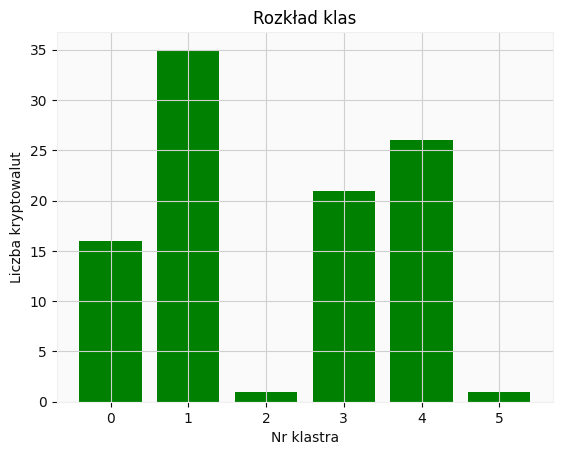

In [431]:
plt.bar(clustered_pca_his.index, clustered_pca_his['class'], color='green')
plt.title("Rozkład klas")
plt.xlabel('Nr klastra')
plt.ylabel('Liczba kryptowalut')
plt.show()

Można zauważyć, że na powyższym histogramie do dwóch klastrów zostało przydzielone tylko po jednej walucie. Jest to kryptowaluta upadła oraz kryptowaluta niedawno powstała. Oby dwa tokeny w dużym stopniu odstają od pozostałych.

In [432]:
Cluster0, Cluster1, Cluster2, Cluster3, Cluster4, Cluster5, = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
Cluster0['Klaster 0'] = clustered_pca['name'].loc[clustered_pca['class'] == 0]
Cluster1['Klaster 1'] = clustered_pca['name'].loc[clustered_pca['class'] == 1]
Cluster2['Klaster 2'] = clustered_pca['name'].loc[clustered_pca['class'] == 2]
Cluster3['Klaster 3'] = clustered_pca['name'].loc[clustered_pca['class'] == 3]
Cluster4['Klaster 4'] = clustered_pca['name'].loc[clustered_pca['class'] == 4]
Cluster5['Klaster 5'] = clustered_pca['name'].loc[clustered_pca['class'] == 5]
Cluster0.reset_index(drop=True, inplace=True)
Cluster1.reset_index(drop=True, inplace=True)
Cluster2.reset_index(drop=True, inplace=True)
Cluster3.reset_index(drop=True, inplace=True)
Cluster4.reset_index(drop=True, inplace=True)
Cluster5.reset_index(drop=True, inplace=True)
results = pd.concat( [Cluster0, Cluster1, Cluster2, Cluster3, Cluster4, Cluster5], axis=1)
results = results.fillna("")
results

,Klaster 0,Klaster 1,Klaster 2,Klaster 3,Klaster 4,Klaster 5
0,avalanche,1inchnetwork,terraclassic,ankr,aave,aptos
1,axieinfinity,algorand,,chiliz,arweave,
2,binancecoin,amp,,decentraland,balancer,
3,bitcoin,aragon,,dogecoin,binaryx,
4,cardano,astar,,ecash,compound,
5,chainlink,audius,,fantom,dash,
6,cosmos,celo,,gala,decred,
7,eos,convexfinance,,holo,flux,
8,ethereum,flow,,iotex,gmx,
9,litecoin,harmony,,oasisnetwork,gnosis,


Kryptowaluty o największym kursie, wielkości rynku czy stopie zwrotu, jak Bitcoin oraz Ethereum, zostały przydzielone do klastra 0. Oznacza to, że model skutecznie wybrał liderów rynku do jeden grupy, gdyż znalazły się w niej dobrze prosperujące kryptowaluty, takie jak: LiteCoin, Cardano, Polkadot, Solana, BinanceCoin. Dużą zaletą modelu jest oddzielenie walut o bardzo niskim kursie, które zaliczyły upadek, tak jak terraclassic. Daje to jasną informację, że należy ich unikać.

#### 9.4.2. Wizualizacja wyników w 2D

In [433]:
tsne = TSNE()
tsne_features = tsne.fit_transform(transformed_crypto_pca)

Dane zostają zredukowane do dwóch wymiarów za pomocą metody t-SNE. Jest to technika nieliniowej redukcji wymiarowości bazującej na podobieństwie między punktami. Metoda ta skupia się na zachowaniu lokalnej struktury danych i działa poprzez minimalizowanie odległości między punktami w gausie.

In [434]:
k_means_df = pd.DataFrame(tsne_features).reset_index(drop=True)
k_means_df.head()

,0,1
0,2.665273,-0.353311
1,3.418711,5.920069
2,2.337507,2.466051
3,1.843010,-5.121086
4,-2.327378,-5.556529


In [435]:
model = KMeans(n_clusters=6, random_state=42)
model.fit(k_means_df)
predictions = model.predict(k_means_df)
k_means_df["class"] = model.labels_
k_means_df.head()

,0,1,class
0,2.665273,-0.353311,5
1,3.418711,5.920069,4
2,2.337507,2.466051,1
3,1.843010,-5.121086,2
4,-2.327378,-5.556529,3


Dwuwymiarowy zbiór kryptowalut został podzielony na 6 klas.

In [436]:
k_means_his = pd.DataFrame()
k_means_his['class'] = k_means_df['class'].value_counts()
k_means_his

,class
4,22
3,22
5,20
0,14
1,13
2,9


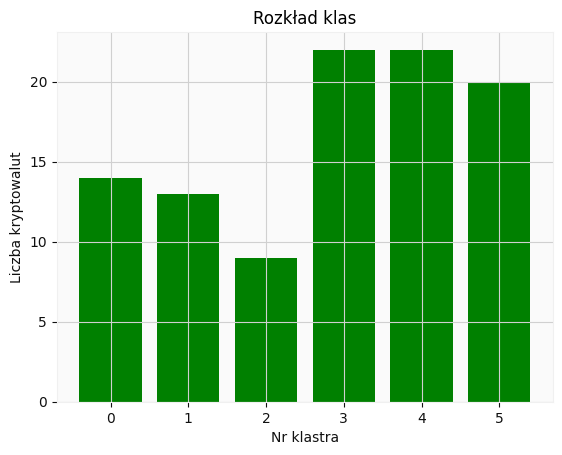

In [437]:
plt.bar(k_means_his.index, k_means_his['class'], color='green')
plt.title("Rozkład klas")
plt.xlabel('Nr klastra')
plt.ylabel('Liczba kryptowalut')
plt.show()

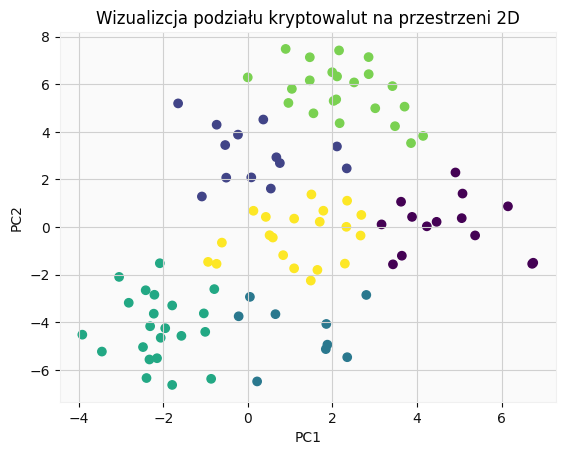

In [438]:
plt.scatter(k_means_df[0], k_means_df[1], c=k_means_df['class'])
plt.title("Wizualizcja podziału kryptowalut na przestrzeni 2D")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

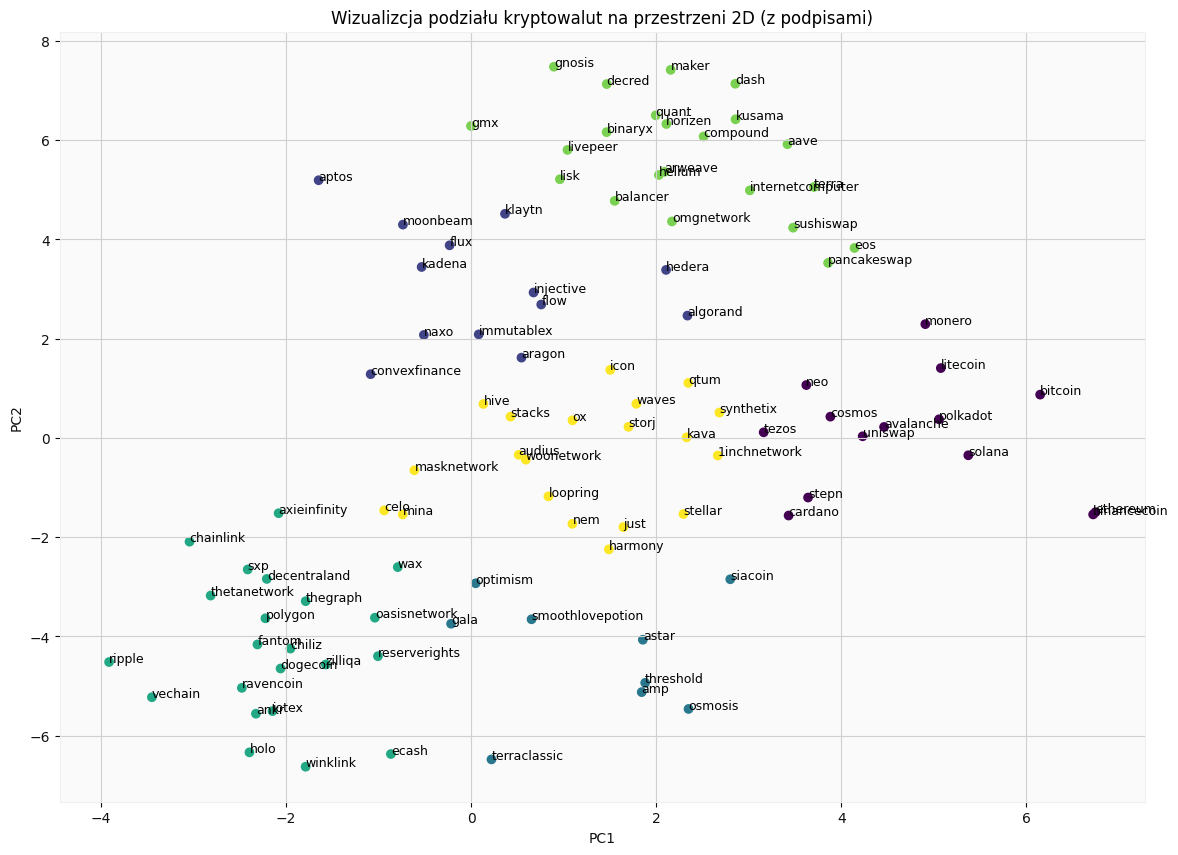

In [439]:
plt.figure(figsize = (14,10))
plt.scatter(k_means_df[0], k_means_df[1], c=k_means_df['class'])
plt.title("Wizualizcja podziału kryptowalut na przestrzeni 2D (z podpisami)")
plt.xlabel('PC1')
plt.ylabel('PC2')
for i, s in enumerate(df.index):
    plt.annotate(s, (k_means_df[0][i], k_means_df[1][i]), fontsize=9)
plt.show()

Klastrowanie dwuwymiarowych danych jest zabiegiem czysto wizualnym i nie należy kierować się jego wynikami przy dokonywaniu decyzji inwestycyjnych. Pewna część informacji została jednak zachowana, dzięki czemu możemy zaobserwować, że największe kryptowaluty znajdują się w dwóch klastrach (na wykresie żółty i zielony). Tym razem model nie był juz w stanie znaleźć kryptowalut wyraźnie odstających od reszty, co podważa jego wiarygodność.